# 0.0 Imports

In [1]:
import pandas                 as pd
import seaborn                as sns
import numpy                  as np
import matplotlib.pyplot      as plt
import statsmodels.api        as sm


from statsmodels.stats.diagnostic         import het_breuschpagan
from statsmodels.stats.stattools          import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib                           import gridspec
from IPython.display                      import Image
from IPython.core.display                 import HTML
from scipy                                import stats

## 0.1 Funções de apoio

In [2]:
#ajusta graficos
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
        
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
#Retirar notação cientifica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def composicao_histograma_boxplot(dataframe, coluna, 
                                 titulo=None, label_x=None, label_y_hist='Frequência',
                                 fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                                 num_bins='auto', range_bins=None, largura_bin=None,
                                 tamanho_figura=(12, 8), proporcoes=(0.15, 0.85), 
                                 espacamento=0.02, mostrar_kde=True,
                                 cor_hist='skyblue', alpha_hist=0.7,
                                 cor_boxplot='lightblue', mostrar_medias_boxplot=True,
                                 mostrar_linhas_estatisticas=True, mostrar_grid=True,
                                 estilo_grid='--', alpha_grid=0.5):
    """
    Cria composição de boxplot e histograma com múltiplas opções de customização
    
    Parâmetros:
    -----------
    dataframe : DataFrame
        DataFrame com os dados
    coluna : str
        Nome da coluna numérica para análise
    titulo : str
        Título do gráfico (se None, usa nome da coluna)
    label_x : str
        Label do eixo X (se None, usa nome da coluna)
    label_y_hist : str
        Label do eixo Y do histograma
    fonte_titulo : int
        Tamanho da fonte do título
    fonte_eixos : int
        Tamanho da fonte dos eixos
    fonte_ticks : int
        Tamanho da fonte dos ticks
    num_bins : int ou str
        Número de bins ou 'auto', 'fd', 'doane', etc.
    range_bins : tuple
        Intervalo dos bins (min, max)
    largura_bin : float
        Largura fixa dos bins (sobrescreve num_bins se especificado)
    tamanho_figura : tuple
        Tamanho da figura (largura, altura)
    proporcoes : tuple
        Proporções dos subplots (boxplot, histograma)
    espacamento : float
        Espaçamento entre subplots
    mostrar_kde : bool
        Se True, mostra linha de densidade (KDE)
    cor_hist : str
        Cor do histograma
    alpha_hist : float
        Transparência do histograma
    cor_boxplot : str
        Cor do boxplot
    mostrar_medias_boxplot : bool
        Se True, mostra média no boxplot
    mostrar_linhas_estatisticas : bool
        Se True, mostra linhas de média, mediana e moda
    mostrar_grid : bool
        Se True, mostra grid
    estilo_grid : str
        Estilo da linha do grid
    alpha_grid : float
        Transparência do grid
    """
    
    # Valores padrão
    if titulo is None:
        titulo = f'Distribuição de {coluna}'
    
    if label_x is None:
        label_x = coluna
    
    # Configurar figura e subplots
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        figsize=tamanho_figura,
        gridspec_kw={
            "height_ratios": proporcoes,
            "hspace": espacamento
        }
    )
    
    # ========== BOXPLOT (PARTE SUPERIOR) ==========
    boxplot_props = {
        'color': cor_boxplot,
        'showfliers': True,
        'whis': 1.5
    }
    
    if mostrar_medias_boxplot:
        boxplot_props.update({
            'showmeans': True,
            'meanline': True,
            'meanprops': {
                "color": "red", 
                "linewidth": 1.5, 
                "linestyle": "--",
                "label": "Média"
            },
            'medianprops': {
                "color": "green", 
                "linewidth": 1.5, 
                "linestyle": "-",
                "label": "Mediana"
            }
        })
    
    # Criar boxplot
    sns.boxplot(
        data=dataframe,
        x=coluna,
        ax=ax1,
        **boxplot_props
    )
    
    # Configurar boxplot
    ax1.set_ylabel('Boxplot', fontsize=fonte_eixos-2)
    ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
    # ========== HISTOGRAMA (PARTE INFERIOR) ==========
    histplot_kwargs = {
        'data': dataframe,
        'x': coluna,
        'kde': mostrar_kde,
        'color': cor_hist,
        'alpha': alpha_hist,
        'ax': ax2
    }
    
    # Configurar bins
    if largura_bin is not None:
        bins_array = np.arange(
            dataframe[coluna].min() if range_bins is None else range_bins[0],
            dataframe[coluna].max() if range_bins is None else range_bins[1] + largura_bin,
            largura_bin
        )
        histplot_kwargs['bins'] = bins_array
    else:
        histplot_kwargs['bins'] = num_bins
        if range_bins is not None:
            histplot_kwargs['binrange'] = range_bins
    
    # Criar histograma
    sns.histplot(**histplot_kwargs)
    
    # Configurar histograma
    ax2.set_xlabel(label_x, fontsize=fonte_eixos)
    ax2.set_ylabel(label_y_hist, fontsize=fonte_eixos)
    
    # ========== CONFIGURAÇÕES GERAIS ==========
    # Adicionar linhas estatísticas no histograma
    if mostrar_linhas_estatisticas:
        media = dataframe[coluna].mean()
        mediana = dataframe[coluna].median()
        
        ax2.axvline(media, color="red", linestyle="--", linewidth=2, label=f"Média: {media:.2f}")
        ax2.axvline(mediana, color="green", linestyle="-", linewidth=2, label=f"Mediana: {mediana:.2f}")
        
        # Moda (pode haver múltiplas modas)
        try:
            moda = dataframe[coluna].mode()[0]
            ax2.axvline(moda, color="orange", linestyle=":", linewidth=2, label=f"Moda: {moda:.2f}")
        except:
            pass
        
        ax2.legend(fontsize=fonte_ticks-2)
    
    # Adicionar grid
    if mostrar_grid:
        for ax in (ax1, ax2):
            ax.grid(True, linestyle=estilo_grid, color="gray", alpha=alpha_grid)
            ax.set_axisbelow(True)
    
    # Configurar fontes dos ticks
    for ax in (ax1, ax2):
        ax.tick_params(axis='both', which='major', labelsize=fonte_ticks)
    
    # Título geral
    fig.suptitle(titulo, fontsize=fonte_titulo, fontweight='bold', y=0.95)
    
    #plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)


def run_breuschpagan_test(model_name, model_obj, X_data):
    """
    Executa o teste de Breusch-Pagan para verificar homocedasticidade.
    H0: Homocedasticidade (variância dos resíduos é constante)
    H1: Heterocedasticidade (variância dos resíduos não é constante)
    """
    # Adicionar uma constante à variável independente para o teste (se ainda não tiver)
    X_test = sm.add_constant(X_data) if X_data.shape[1] == 1 else X_data
    estatistica, p_valor, f_estatistica, f_p_valor = het_breuschpagan(model_obj.resid, X_test)
    print(f"\n--- Teste de Breusch-Pagan para {model_name} ---")
    print(f"Estatística de Teste: {estatistica:.4f}")
    print(f"P-valor: {p_valor:.4f}")
    print('')
    print(f"F-Estatística: {f_estatistica:.4f}")
    print(f"P-valor F: {f_p_valor:.4f}")
    print('')

    if p_valor < 0.05:
        print(f"Conclusão: Rejeitamos H0. Há evidências de heterocedasticidade no modelo {model_name}.")
    else:
        print(f"Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo {model_name}.")


def run_shapiro_wilk_test(model_name, residuals):
    """
    Executa o teste de Shapiro-Wilk para verificar a normalidade dos resíduos.
    H0: Os resíduos seguem uma distribuição normal.
    H1: Os resíduos não seguem uma distribuição normal.
    """
    estatistica_shapiro, p_shapiro = stats.shapiro(residuals)
    print(f"\n--- Teste de Shapiro-Wilk para {model_name} ---")
    print(f"Estatística de Teste: {estatistica_shapiro:.4f}")
    print(f"P-valor: {p_shapiro:.4f}")
    

    if p_shapiro < 0.05:
        print(f"\nConclusão: Rejeitamos H0. Os resíduos do modelo {model_name} não seguem uma distribuição normal.")
    else:
        print(f"\nConclusão: Não rejeitamos H0. Os resíduos do modelo {model_name} seguem uma distribuição normal.")


def plot_qq(model_name, residuals):
    """
    Gera um QQ-plot para verificar a normalidade dos resíduos.
    """
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot - {model_name} (Normalidade dos Resíduos)", fontsize=14)
    plt.xlabel('Quantis Teóricos', fontsize=12)
    plt.ylabel('Quantis Amostrais dos Resíduos', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_standardized_residuals(model_name, model_obj, X_data):
    """
    Gera um gráfico de resíduos padronizados para identificar outliers.
    """
    residuos_padronizados = model_obj.get_influence().resid_studentized_internal

    plt.figure(figsize=(8, 6))
    plt.scatter(X_data, residuos_padronizados)
    plt.axhline(y=3, color='r', linestyle='--', label='Limite Superior (+3)')
    plt.axhline(y=-3, color='r', linestyle='--', label='Limite Inferior (-3)')
    plt.title(f'Gráfico de Resíduos Padronizados para {model_name} (Identificação de Outliers)', fontsize=14)
    plt.xlabel(f'Investimento em {model_name}', fontsize=12)
    plt.ylabel('Resíduos Padronizados', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# 2. Cálculo do VIF
def calculate_vif(dataframe, target_col=None):
    """Calcula VIF para todas as variáveis num DataFrame"""
    if target_col is not None:
        X = dataframe.drop(columns=[target_col])
    else:
        X = dataframe.copy()
    
    X = sm.add_constant(X)  # Adiciona intercepto
    
    vif_data = pd.DataFrame()
    vif_data["Variável"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(len(X.columns))]
    
    # Remove o VIF da constante (geralmente é alto e não interpretável)
    vif_data = vif_data[vif_data['Variável'] != 'const']
    
    return vif_data.sort_values('VIF', ascending=False)






In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Carregando os dados

In [4]:
data = pd.read_csv('propaganda.csv')
data.shape

(200, 4)

# 1.0 Preparação dos Dados

In [5]:
df1 = data.copy()

## 1.1 Dimensão dos dados

In [6]:
print(f'Número de linhas: {data.shape[0]}')

Número de linhas: 200


In [7]:
print(f'Número de colunas: {data.shape[1]}')

Número de colunas: 4


## 1.2 Nome das colunas

In [8]:
df1.columns

Index(['TV', 'Radio', 'Jornal', 'Vendas'], dtype='object')

**Variáveis**

'TV'    --> investimento em campanhas de TV

'Radio' --> investimento em campanhas de rádio

'Jornal' --> investimento em campanhas de rádio

'Vendas' --> retorno das vendas dos produtos/serviços

**Não será necessário renomear as colunas**

## 1.3 Tipo dos dados

In [9]:
df1.dtypes

TV        float64
Radio     float64
Jornal    float64
Vendas    float64
dtype: object

## 1.4 Verificação de Na's

In [10]:
df1.isna().sum()

TV        0
Radio     0
Jornal    0
Vendas    0
dtype: int64

**Não há valores faltantes no dataset.**

## 1.5 Alteração de tipo das variáveis

In [11]:
df1.head()

,TV,Radio,Jornal,Vendas
0,230.10,37.80,69.20,22.10
1,44.50,39.30,45.10,10.40
2,17.20,45.90,69.30,9.30
3,151.50,41.30,58.50,18.50
4,180.80,10.80,58.40,12.90


**Não será necessário modificar o tipo das variáveis**

# 2.0 Análise Descritiva

In [12]:
df2 = df1.copy()

In [13]:
df2.shape

(200, 4)

## 2.1 Análise univariada

### 2.1.1 Calcular estatísticas - variáveis númericas

In [14]:
#dataset variaveis numericas
num_attributes = df2.select_dtypes(include = ['float64'])

In [15]:
# Medidas de tendencia central - media
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T

# Medidas de tendencia central - mediana
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersao

# desvio padrao
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T

# minimo
d2 = pd.DataFrame( num_attributes.apply( min ) ).T

#maximo
d3 = pd.DataFrame( num_attributes.apply( max ) ).T

#range
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

#assimetria - Skew
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

#Curtose - Kurtosis
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#Tabela
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

### 2.1.2 Variável Resposta - Resultado Vendas

In [16]:
# estatísticas
m.iloc[3]

attributes    Vendas
min             1.60
max            27.00
range          25.40
mean           14.02
median         12.90
std             5.20
skew            0.41
kurtosis       -0.41
Name: 3, dtype: object

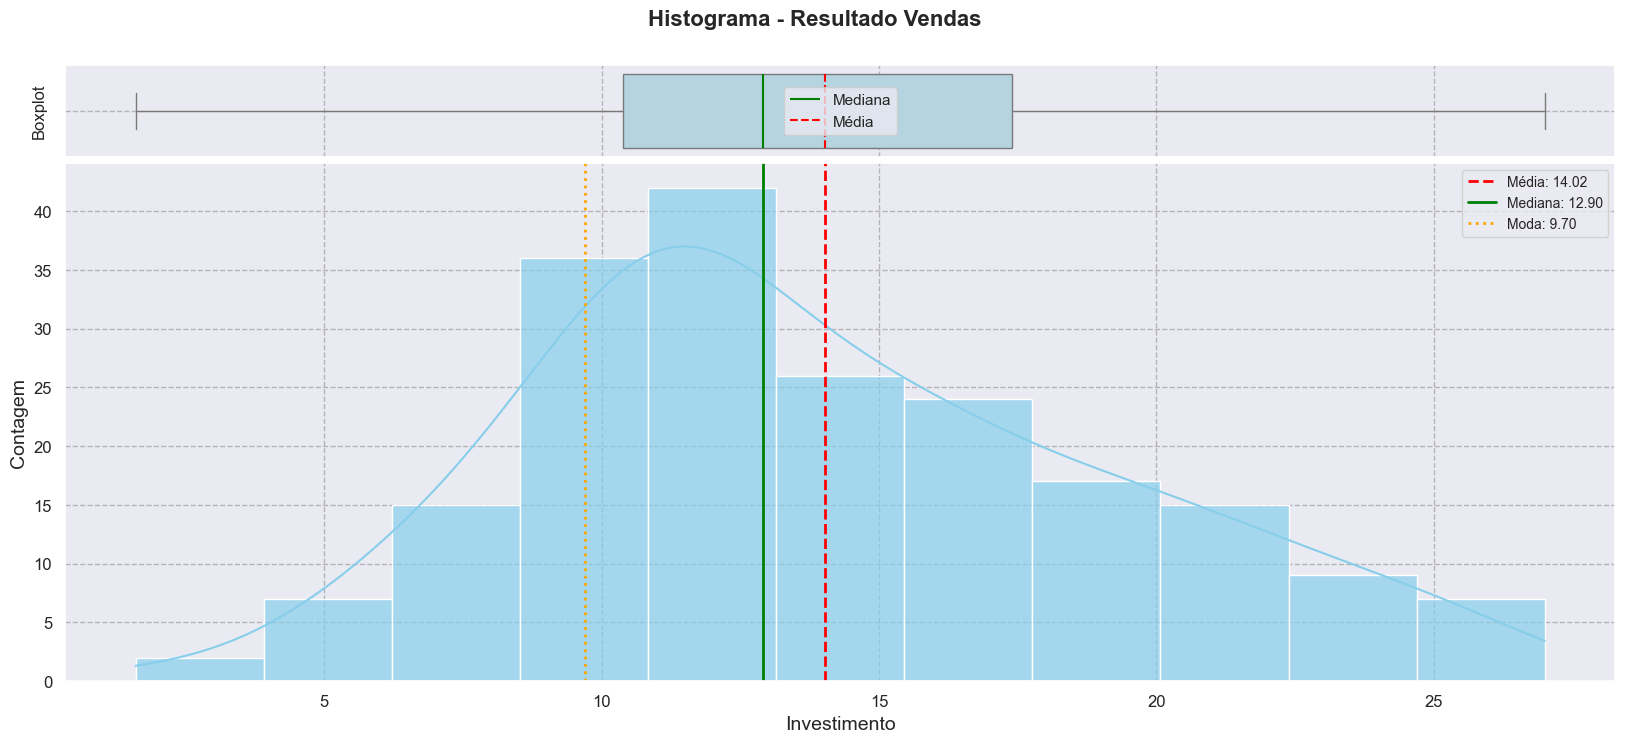

In [17]:
composicao_histograma_boxplot(df2, 'Vendas', 
                              titulo='Histograma - Resultado Vendas', label_x='Investimento', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

### 2.1.3 Variável Investimento TV

In [18]:
# estatísticas
m.iloc[0]

attributes       TV
min            0.70
max          296.40
range        295.70
mean         147.04
median       149.75
std           85.64
skew          -0.07
kurtosis      -1.23
Name: 0, dtype: object

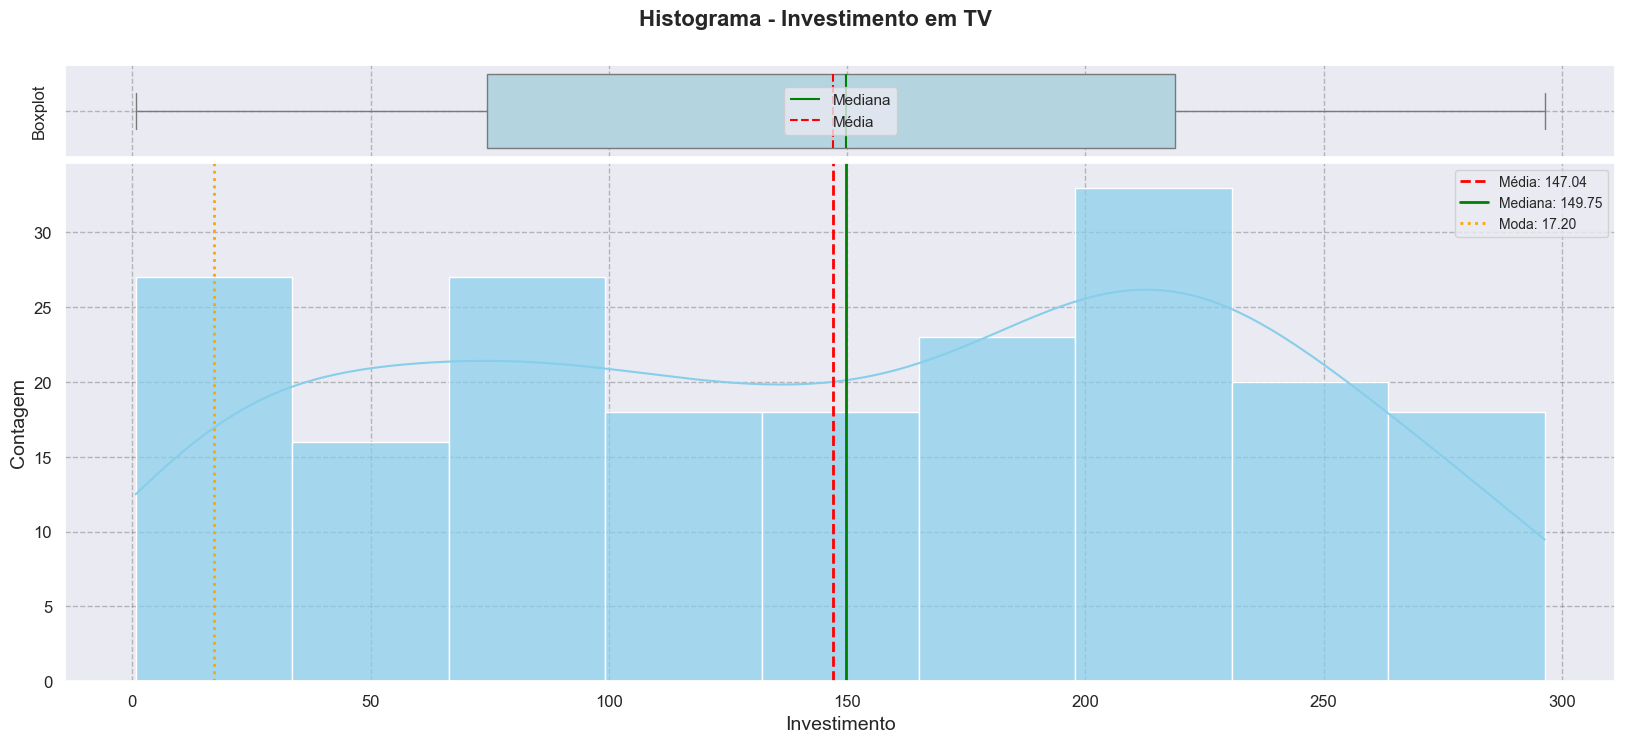

In [19]:
composicao_histograma_boxplot(df2, 'TV', 
                              titulo='Histograma - Investimento em TV', label_x='Investimento', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

### 2.1.4 Variável Investimento Rádio

In [20]:
# estatísticas
m.iloc[1]

attributes    Radio
min            0.00
max           49.60
range         49.60
mean          23.26
median        22.90
std           14.81
skew           0.09
kurtosis      -1.26
Name: 1, dtype: object

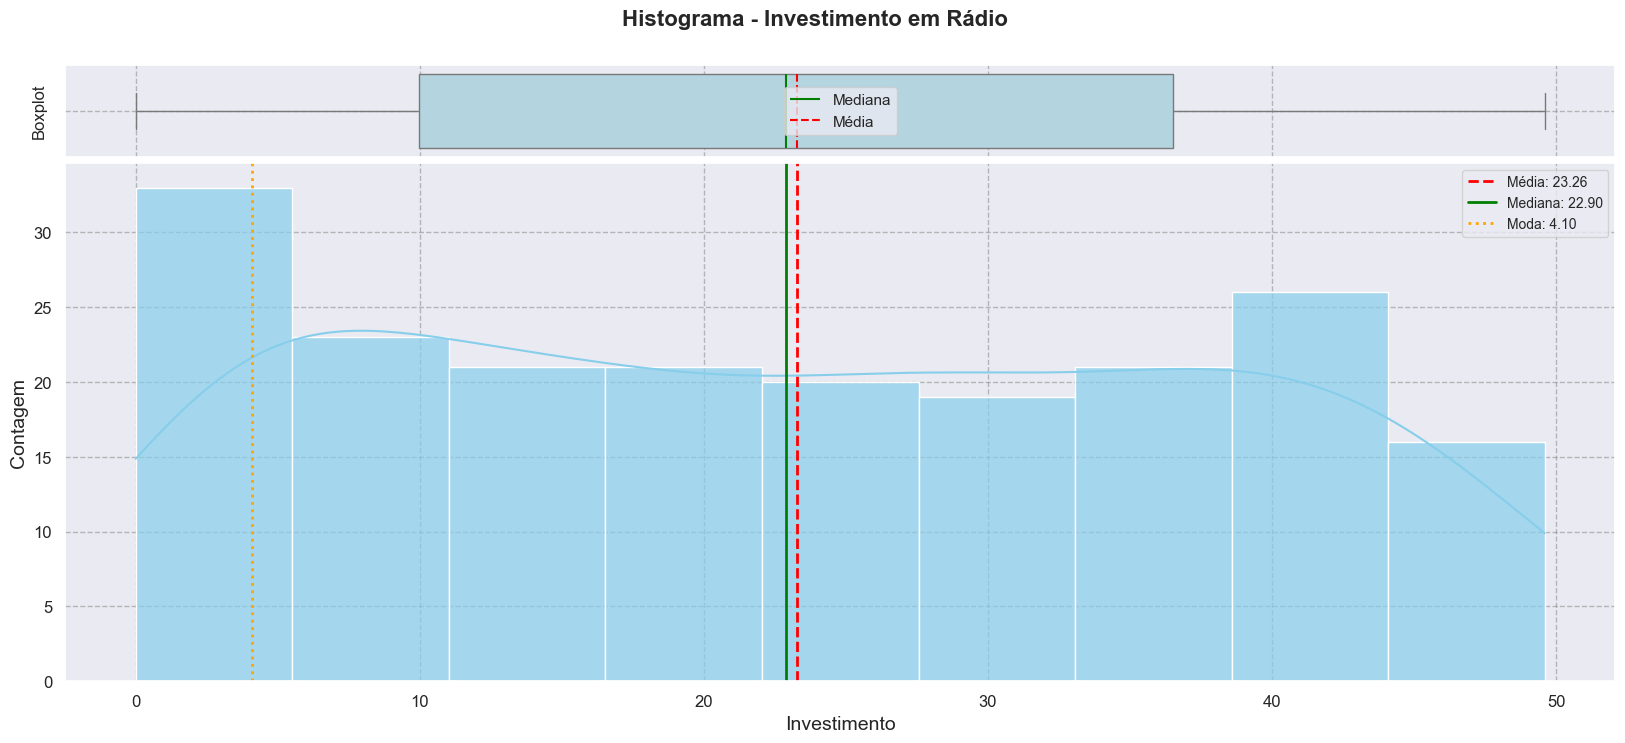

In [21]:
composicao_histograma_boxplot(df2, 'Radio', 
                              titulo='Histograma - Investimento em Rádio', label_x='Investimento', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

### 2.1.5 Variável Investimento Jornal

In [22]:
# estatísticas
m.iloc[2]

attributes    Jornal
min             0.30
max           114.00
range         113.70
mean           30.55
median         25.75
std            21.72
skew            0.89
kurtosis        0.65
Name: 2, dtype: object

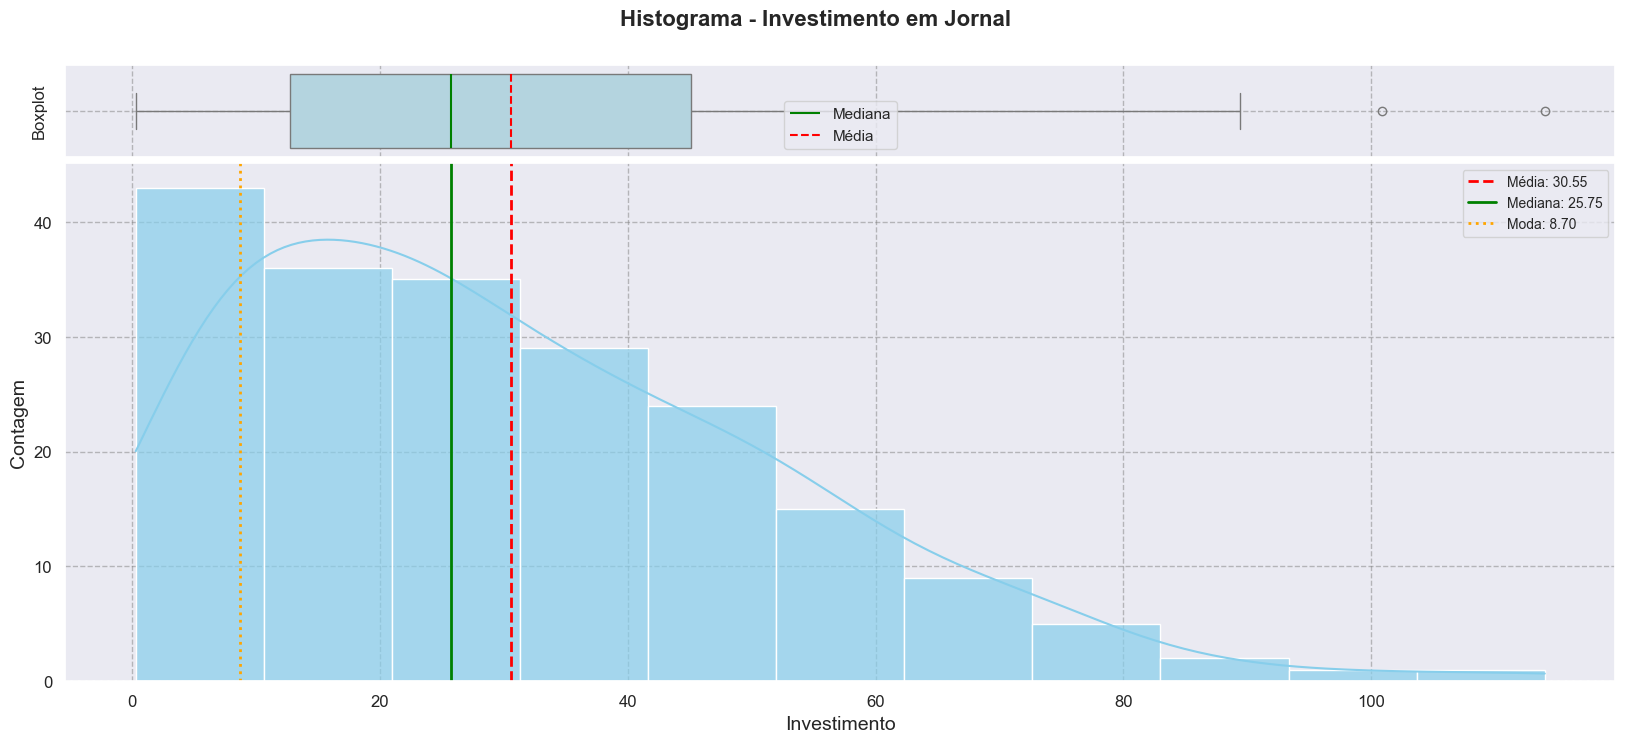

In [23]:
composicao_histograma_boxplot(df2, 'Jornal', 
                              titulo='Histograma - Investimento em Jornal', label_x='Investimento', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

### 2.2.6 Tabela - Estatísticas das variáveis 

In [24]:
# Tabela resumo
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,TV,0.70,296.40,295.70,147.04,149.75,85.64,-0.07,-1.23
1,Radio,0.00,49.60,49.60,23.26,22.90,14.81,0.09,-1.26
2,Jornal,0.30,114.00,113.70,30.55,25.75,21.72,0.89,0.65
3,Vendas,1.60,27.00,25.40,14.02,12.90,5.20,0.41,-0.41


**Não há valores negativos e nem valores a serem removidos após a análise univaridada**

## 2.2 Análise Bivariada

### 2.2.1 Investimento em TV x Resultado vendas

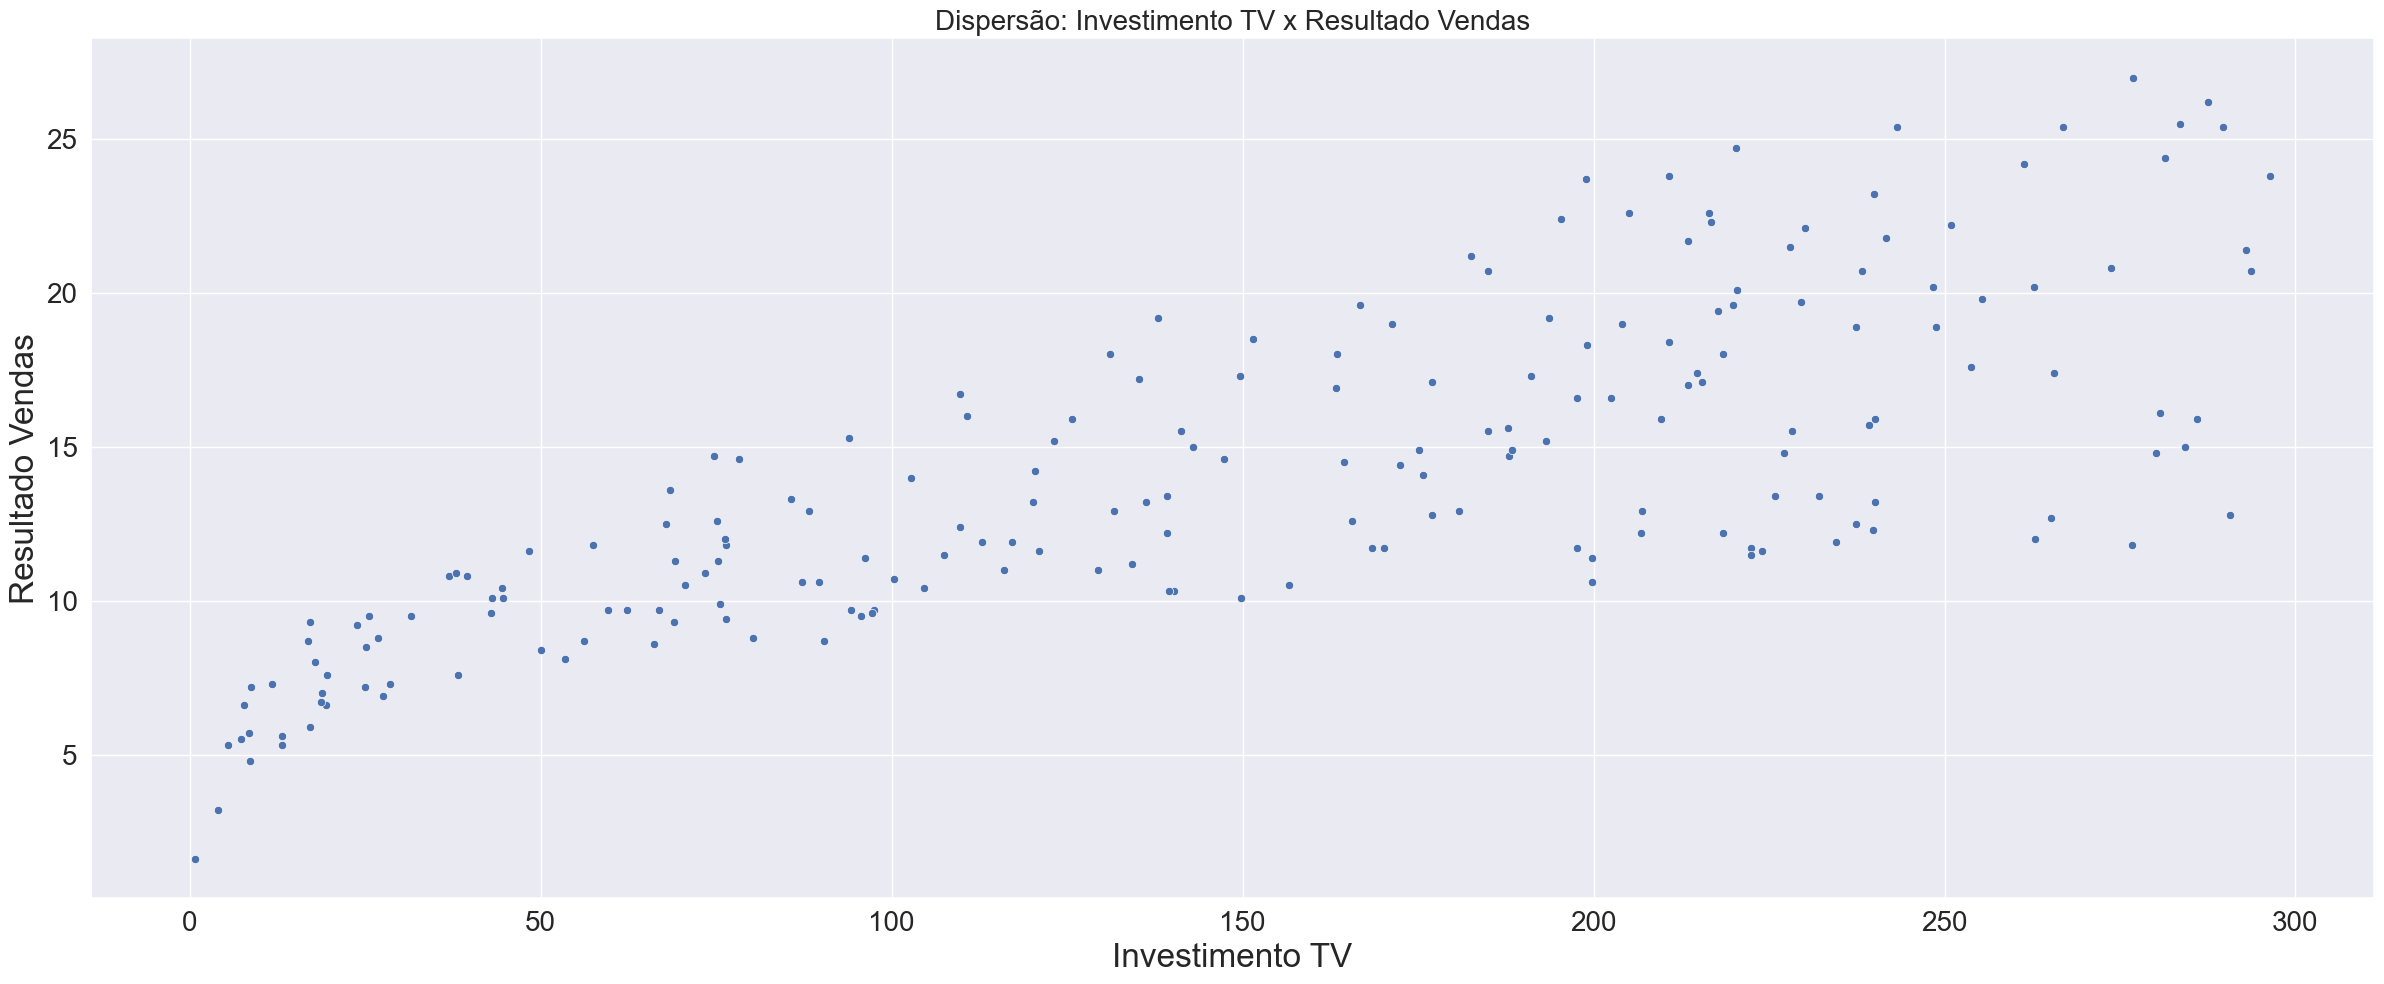

In [25]:
# Gráfico de dispersão
fig = plt.figure( figsize = (24,10) )
sns.scatterplot(data =df2, y='Vendas',x='TV');

plt.title("Dispersão: Investimento TV x Resultado Vendas", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Resultado Vendas',fontsize=24)
plt.xlabel('Investimento TV',fontsize=24)
plt.tight_layout()
plt.show();

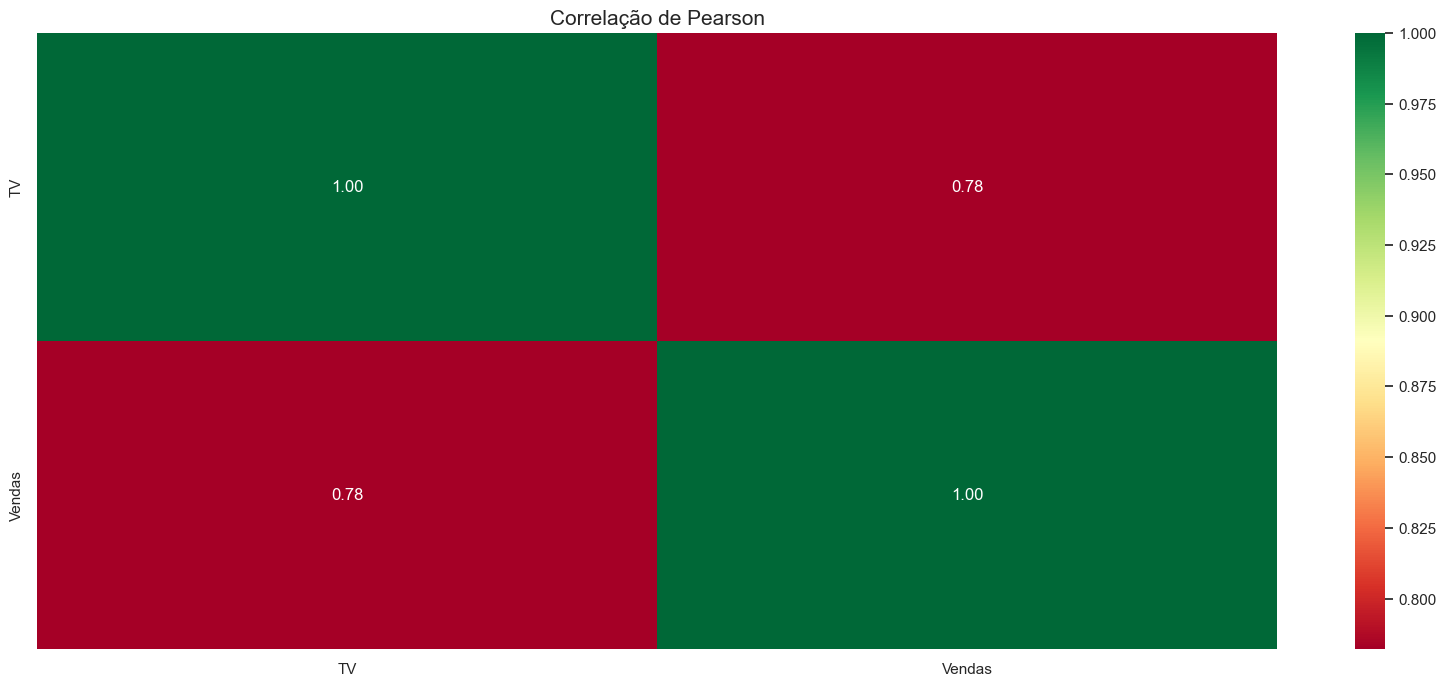

In [26]:
# Correlação
plt.figure(figsize=(20,8))
matriz = df2[['TV', 'Vendas']] 
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

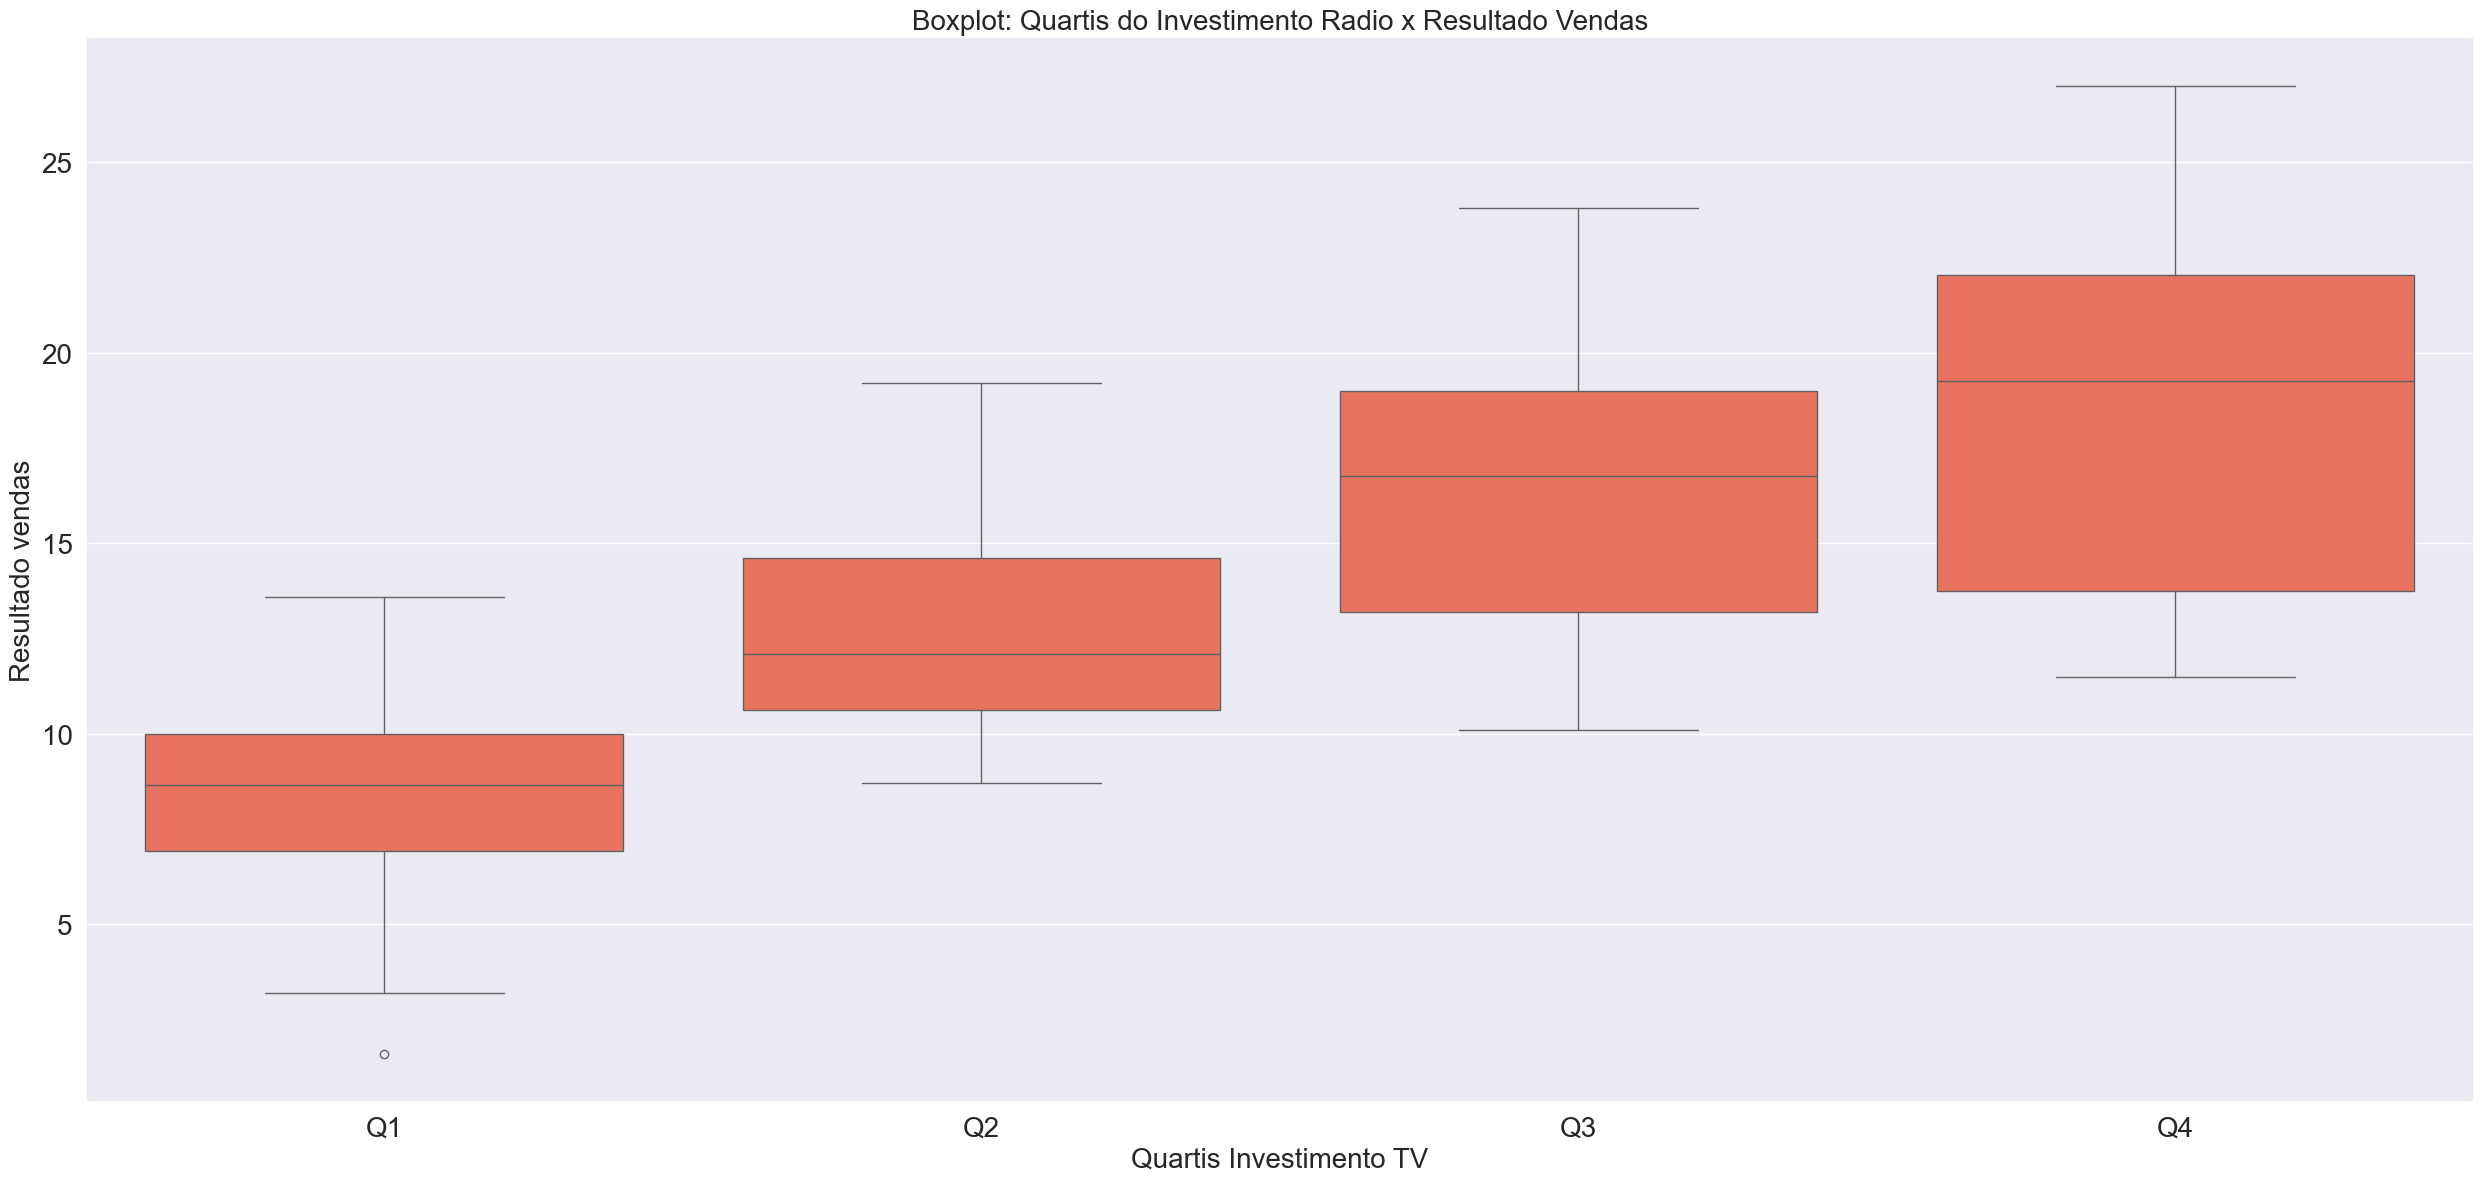

In [27]:
# análise por quartis da variável independente

aux1 = df2.copy()

# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_TV'] = pd.qcut(aux1['TV'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']

# Gera o gráfico boxplot
sns.boxplot(data = aux1, x='quartil_TV', y='Vendas',palette=cores, hue ='quartil_TV', order=aux1['quartil_TV'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Quartis do Investimento Radio x Resultado Vendas", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis Investimento TV',fontsize=20)
plt.ylabel('Resultado vendas',fontsize=20)
plt.tight_layout()
plt.show();

### 2.2.2 Investimento em Radio x Resultado vendas

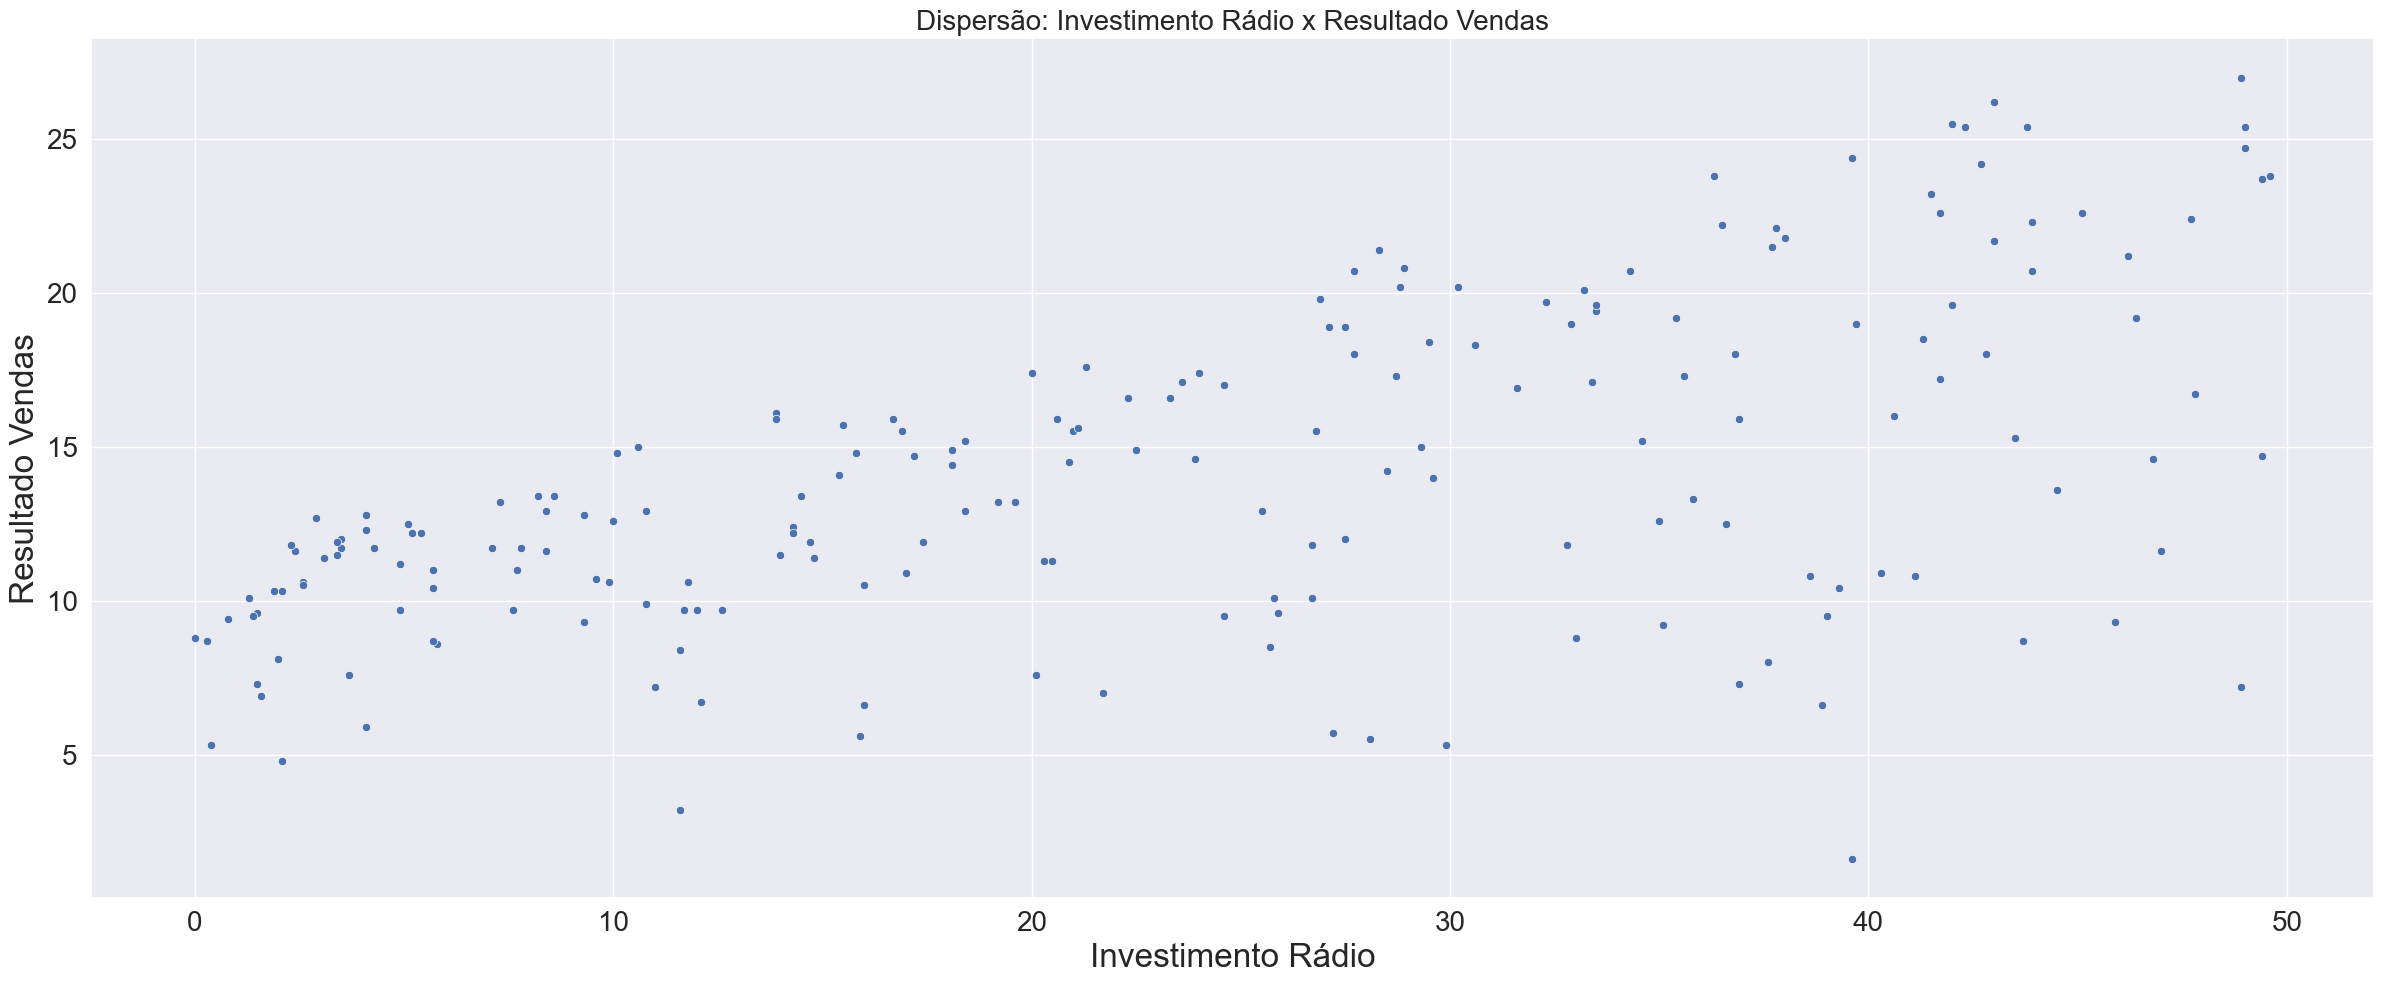

In [28]:
# Gráfico de dispersão
fig = plt.figure( figsize = (24,10) )
sns.scatterplot(data =df2, y='Vendas',x='Radio');

plt.title("Dispersão: Investimento Rádio x Resultado Vendas", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Resultado Vendas',fontsize=24)
plt.xlabel('Investimento Rádio',fontsize=24)
plt.tight_layout()
plt.show();

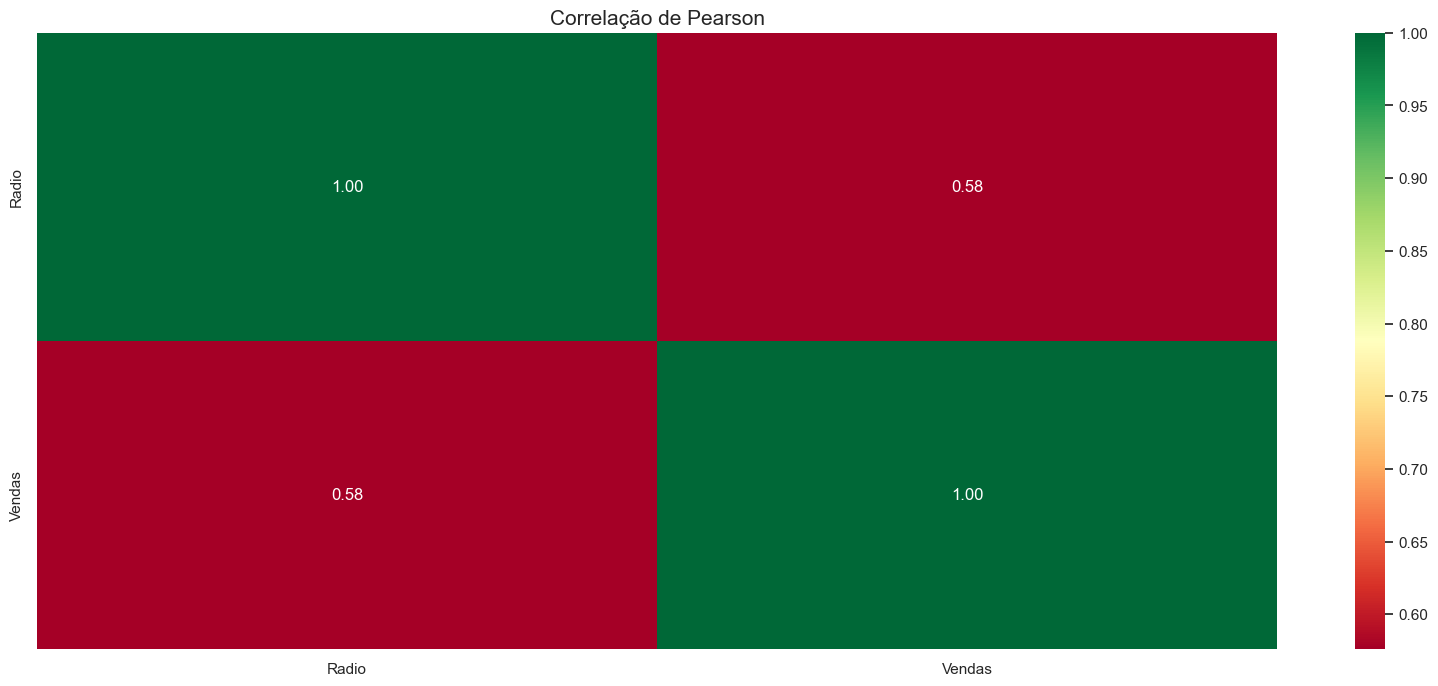

In [29]:
# correlação
plt.figure(figsize=(20,8))
matriz = df2[['Radio', 'Vendas']] 
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

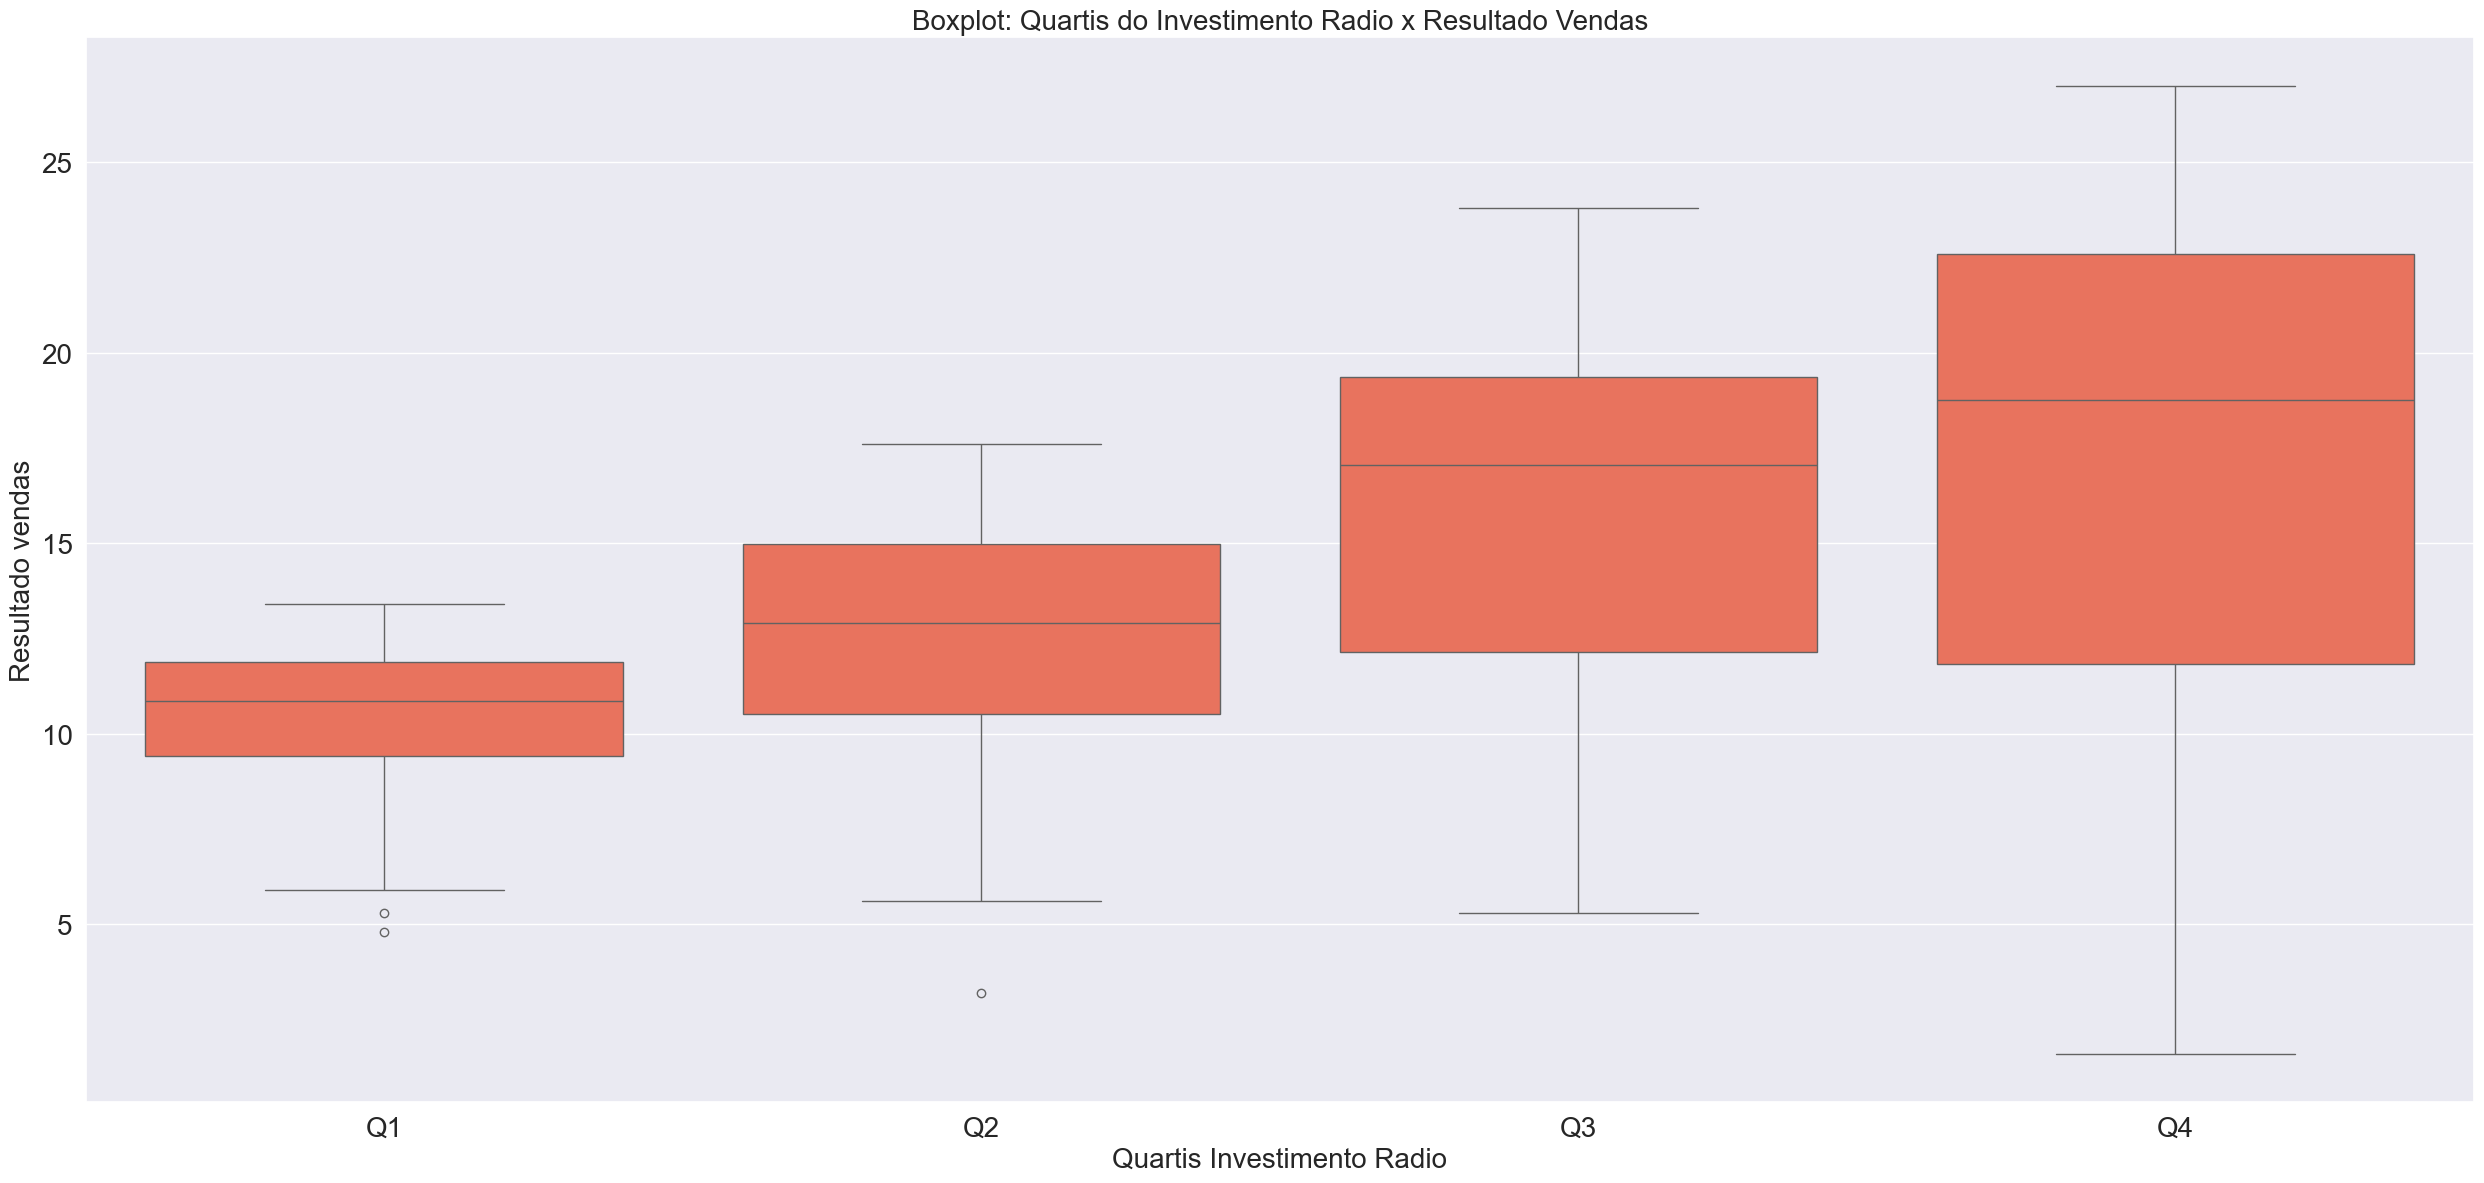

In [30]:
# análise por quartis da variável independente

aux1 = df2.copy()

# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_Radio'] = pd.qcut(aux1['Radio'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']

# gráfico boxplot
sns.boxplot(data = aux1, x='quartil_Radio', y='Vendas',palette=cores, hue ='quartil_Radio', order=aux1['quartil_Radio'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Quartis do Investimento Radio x Resultado Vendas", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis Investimento Radio',fontsize=20)
plt.ylabel('Resultado vendas',fontsize=20)
plt.tight_layout()
plt.show();

### 2.2.3 Investimento em Jornal x Resultado vendas

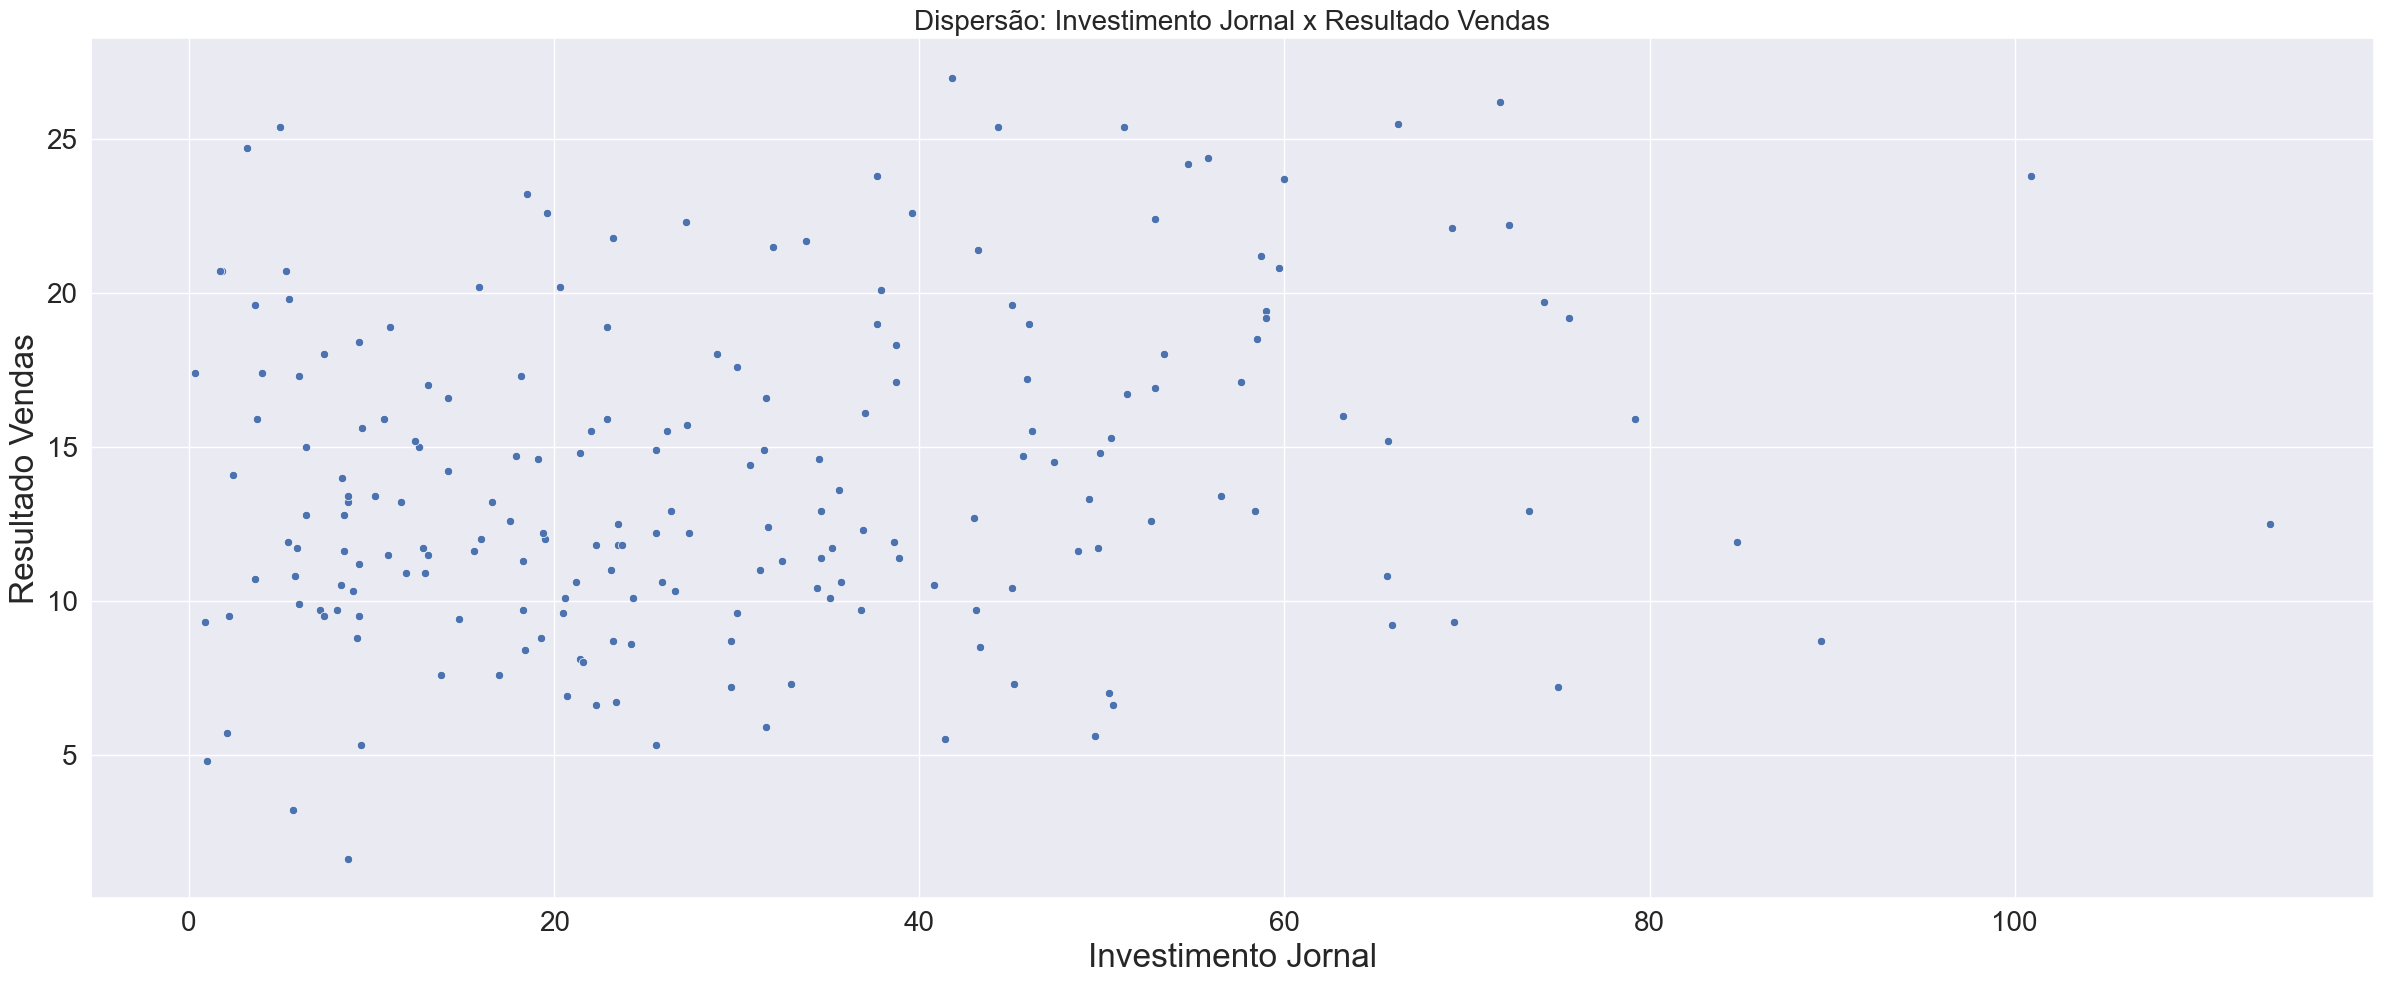

In [31]:
# Gráfico de dispersão
fig = plt.figure( figsize = (24,10) )
sns.scatterplot(data =df2, y='Vendas',x='Jornal');

plt.title("Dispersão: Investimento Jornal x Resultado Vendas", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Resultado Vendas',fontsize=24)
plt.xlabel('Investimento Jornal',fontsize=24)
plt.tight_layout()
plt.show();

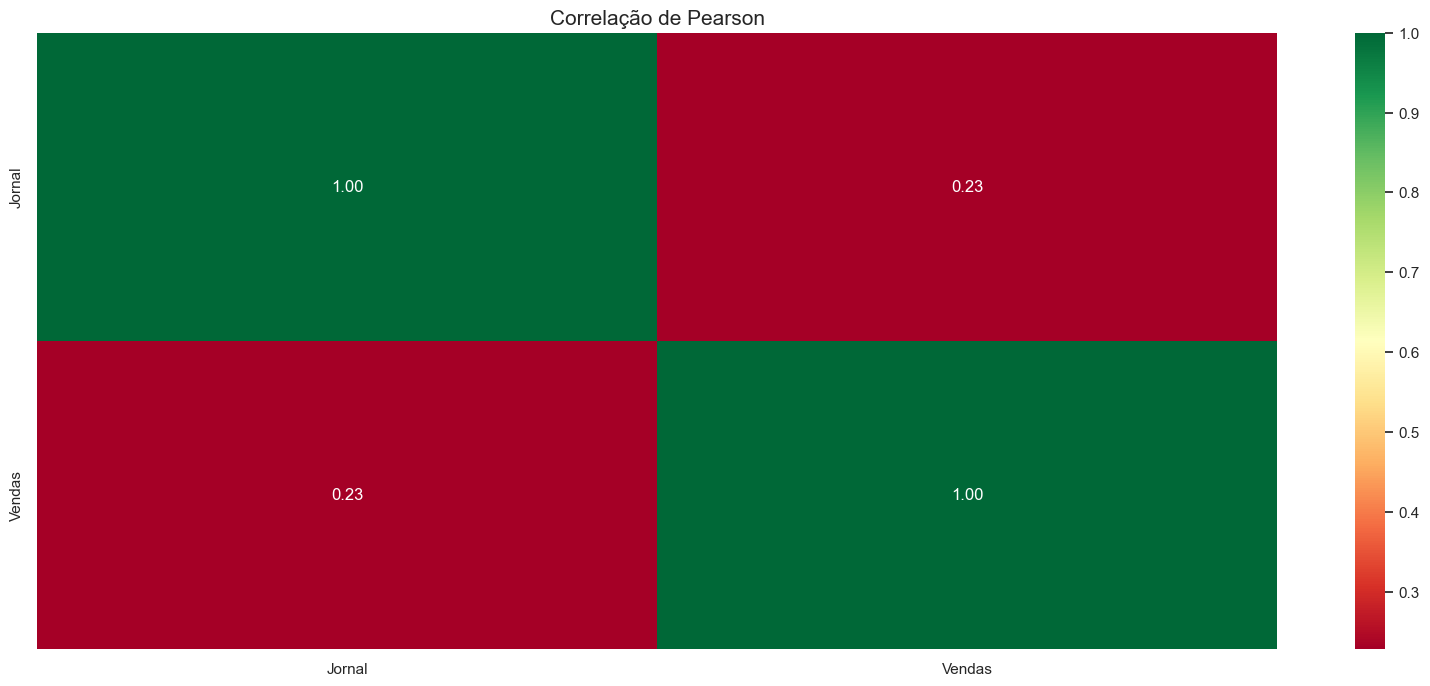

In [32]:
plt.figure(figsize=(20,8))
matriz = df2[['Jornal', 'Vendas']] 
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

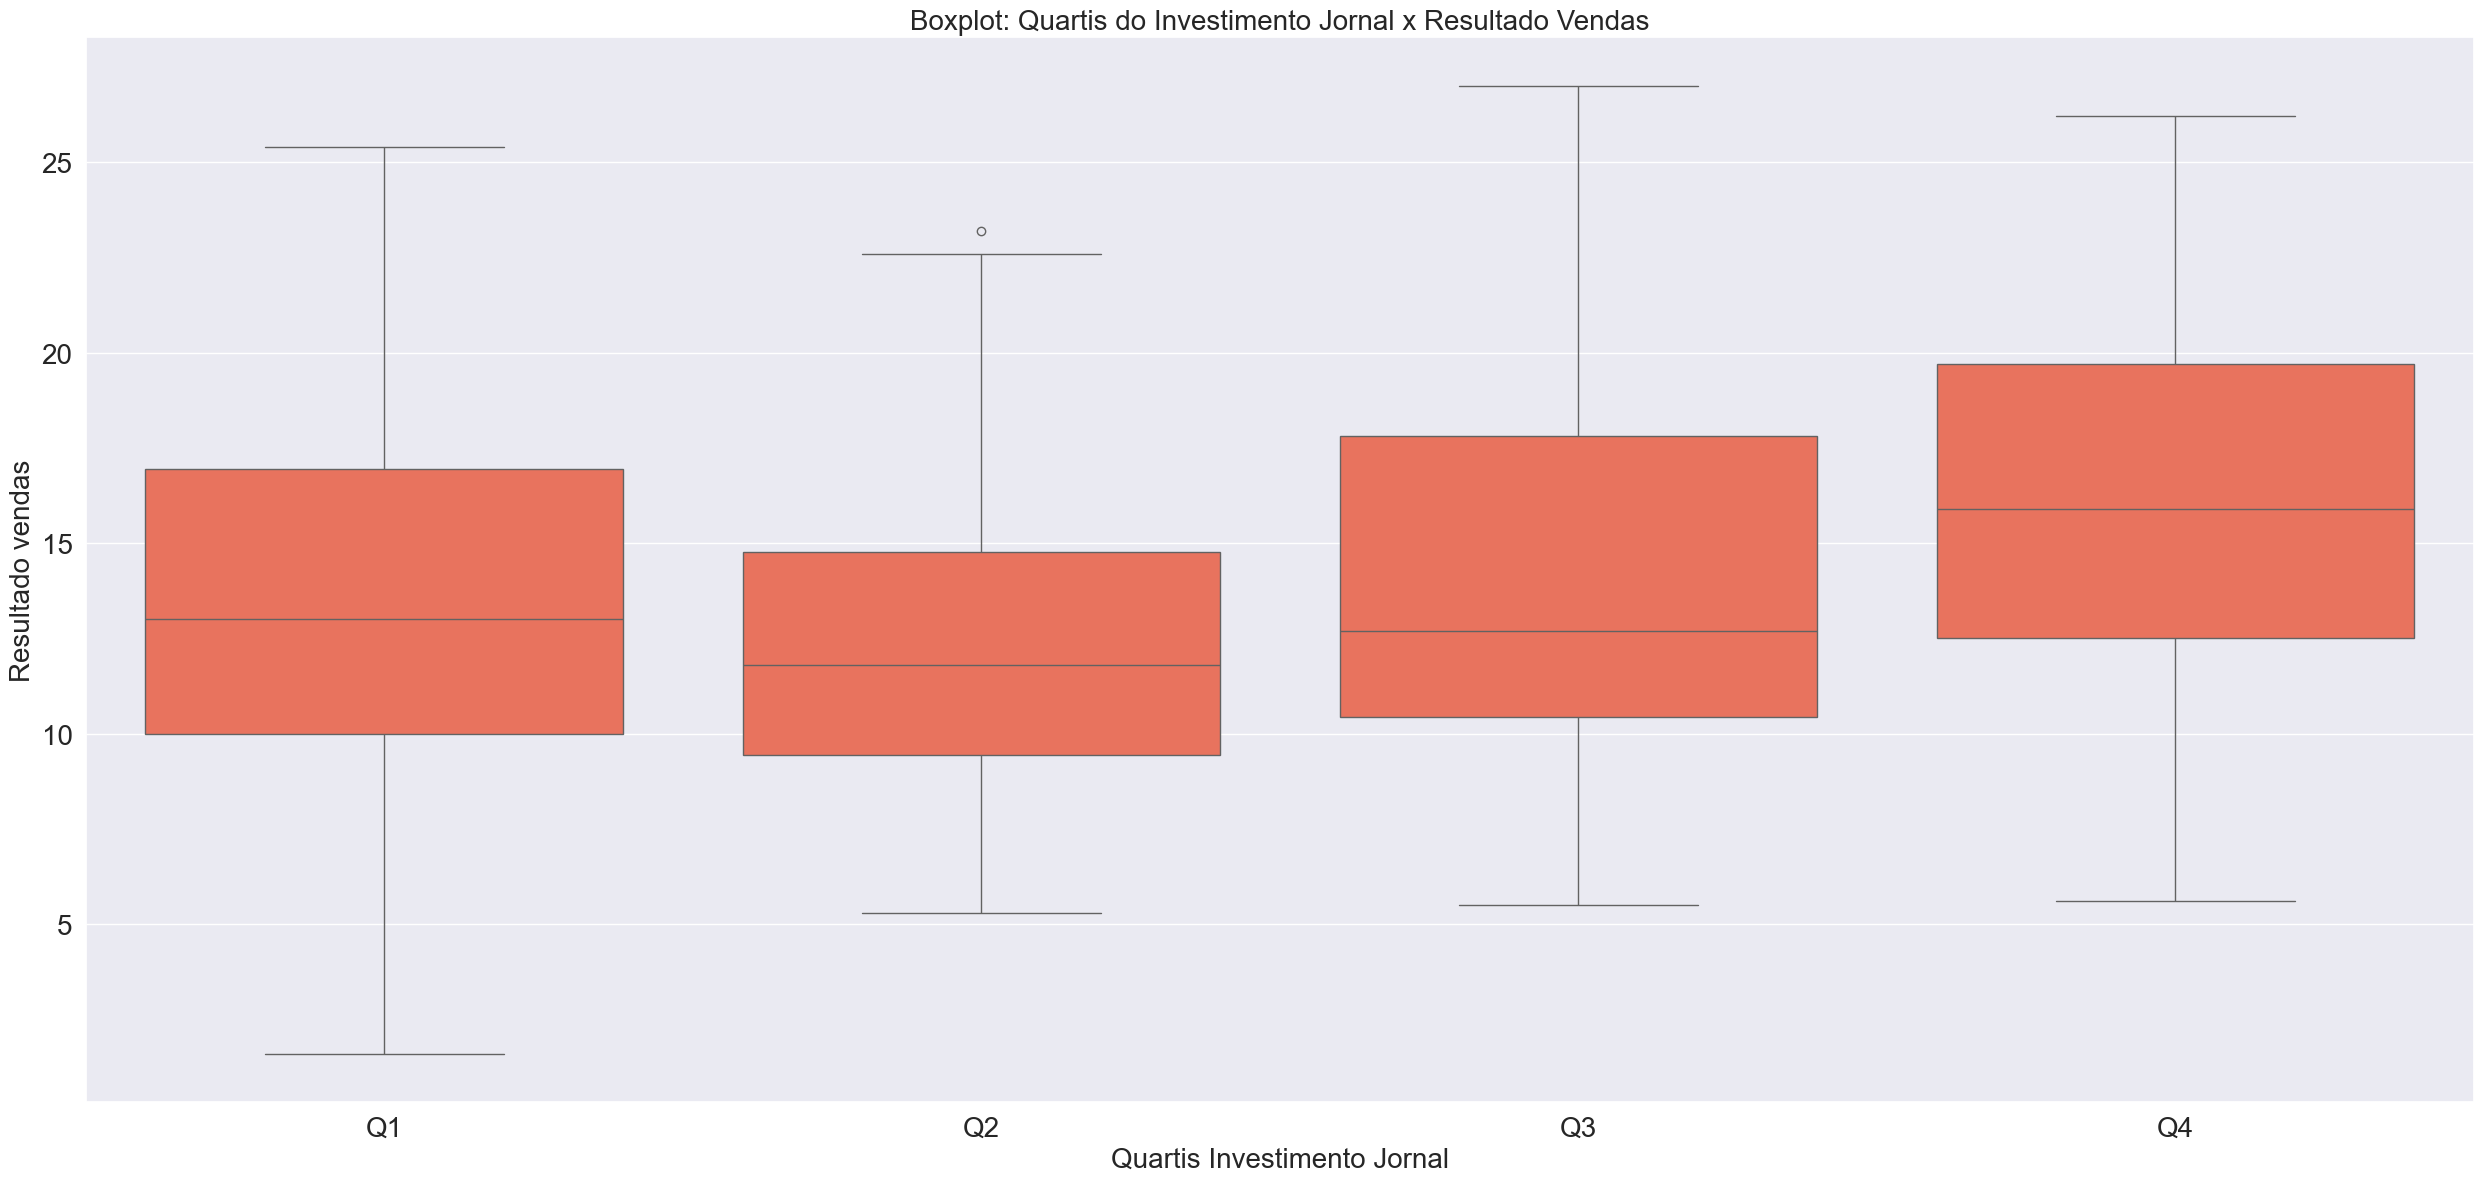

In [33]:
# análise por quartis da variável independente

aux1 = df2.copy()

# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_jornal'] = pd.qcut(aux1['Jornal'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']

# gera o gráfico
sns.boxplot(data = aux1, x='quartil_jornal', y='Vendas',palette=cores, hue ='quartil_jornal', order=aux1['quartil_jornal'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Quartis do Investimento Jornal x Resultado Vendas", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis Investimento Jornal',fontsize=20)
plt.ylabel('Resultado vendas',fontsize=20)
plt.tight_layout()
plt.show();

## 2.3 Análise Multivariada

### 2.3.1 Gráficos de dispersão

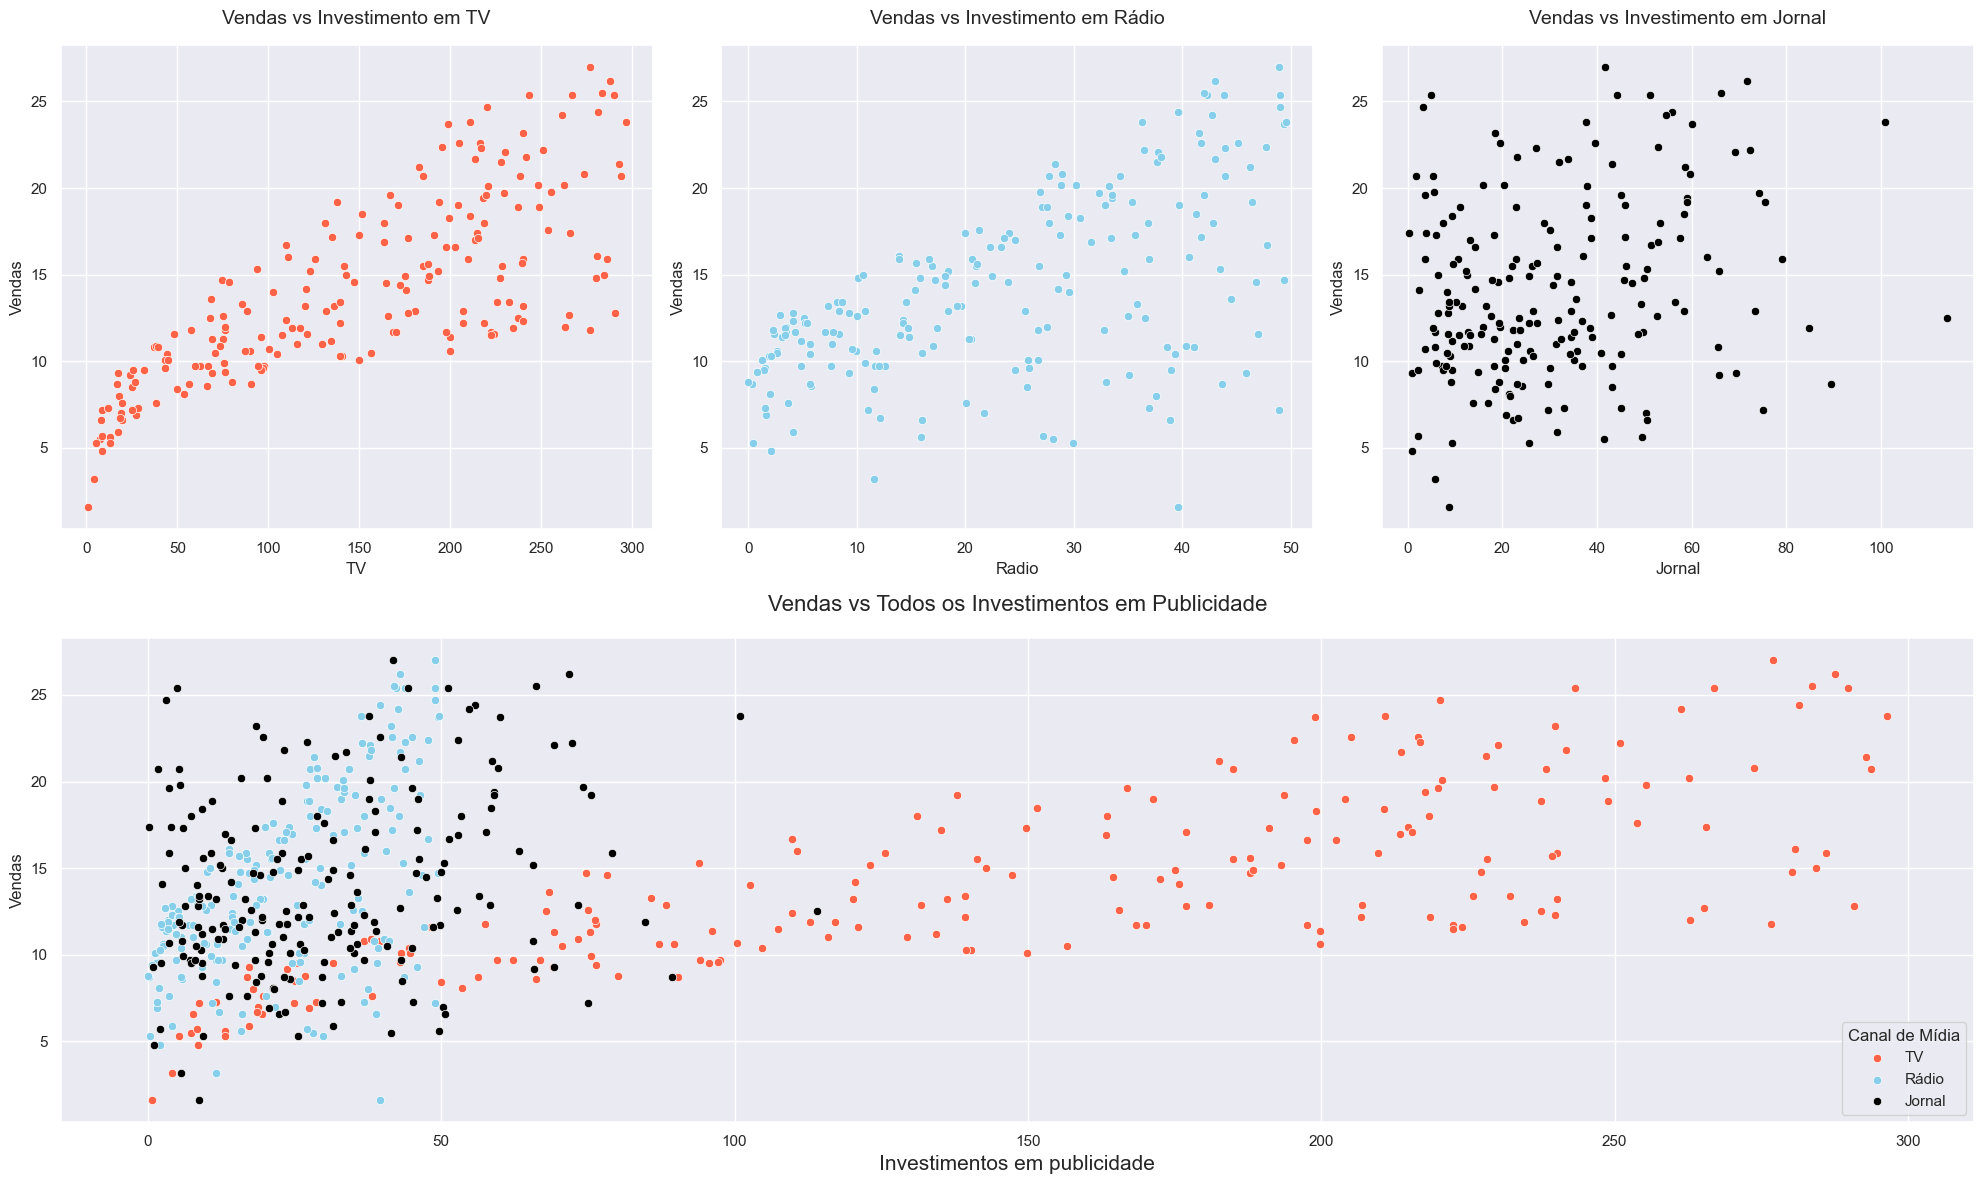

In [34]:

fig= plt.figure(figsize=(20,12))

specs = gridspec.GridSpec(  nrows = 2, ncols = 3, figure = fig )

ax1 = fig.add_subplot( specs[0,0] )
ax2 = fig.add_subplot( specs[0,1]  )
ax3 = fig.add_subplot( specs[0,2]  )
ax4 = fig.add_subplot( specs[1,:]  )

sns.scatterplot(data=df2,y='Vendas',x='TV',ax = ax1, color = 'tomato');
ax1.set_title('Vendas vs Investimento em TV', fontsize=14,  pad=15)

sns.scatterplot(data=df2,y='Vendas',x='Radio',ax = ax2, color = 'skyblue');
ax2.set_title('Vendas vs Investimento em Rádio', fontsize=14,  pad=15)

sns.scatterplot(data=df2,y='Vendas',x='Jornal',ax = ax3,color = 'black');
ax3.set_title('Vendas vs Investimento em Jornal', fontsize=14,  pad=15)


sns.scatterplot(data=df2,y='Vendas',x='TV',     ax = ax4, color = 'tomato' , label='TV');
sns.scatterplot(data=df2,y='Vendas',x='Radio',  ax = ax4, color = 'skyblue' ,label = 'Rádio');
sns.scatterplot(data=df2,y='Vendas',x='Jornal', ax = ax4,color = 'black' ,label='Jornal');
ax4.set_title('Vendas vs Todos os Investimentos em Publicidade', fontsize=16,  pad=20)

ax4.set_xlabel('Investimentos em publicidade', fontsize=15, )
ax4.legend(title='Canal de Mídia');

plt.tight_layout();
plt.show();


# 3.0 Correlação e Covariância

## 3.1 Cálculo de correlação

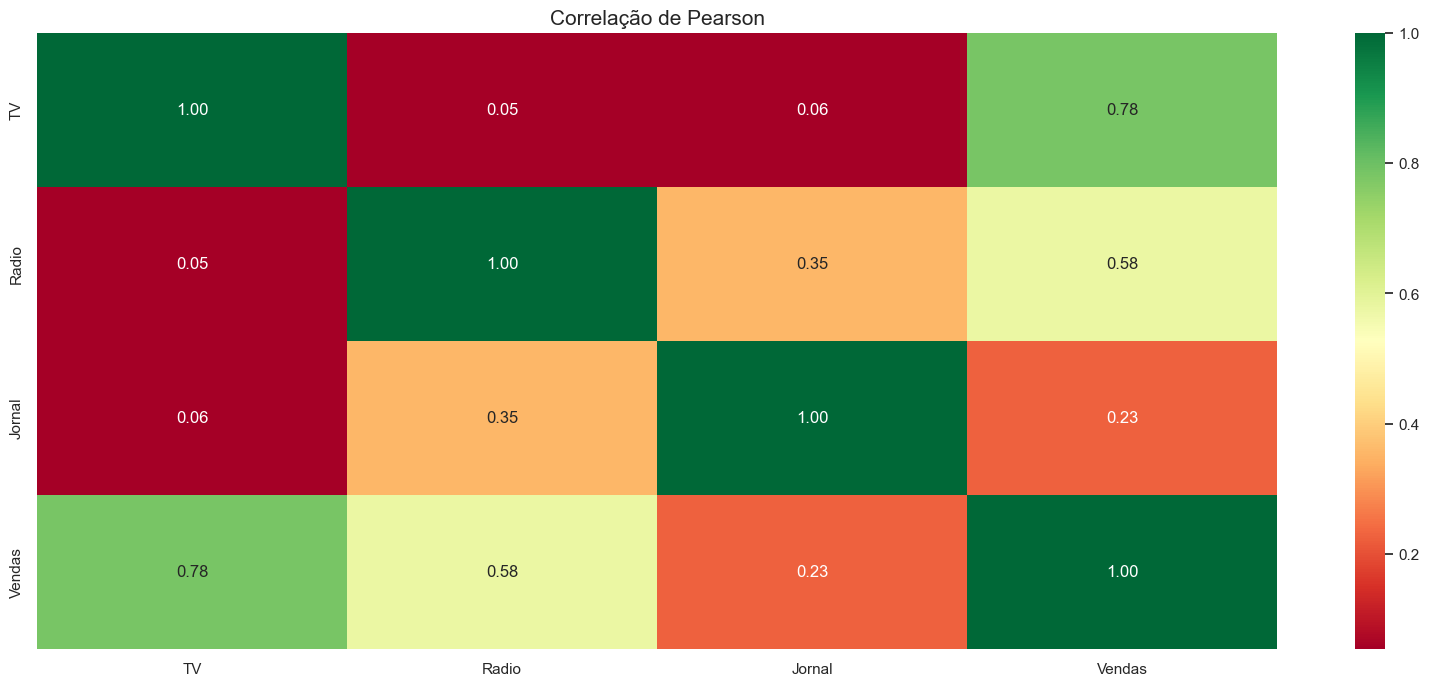

In [35]:
plt.figure(figsize=(20,8))
matriz = df2[['TV','Radio','Jornal', 'Vendas']] 
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

In [36]:
df2.head()

,TV,Radio,Jornal,Vendas
0,230.10,37.80,69.20,22.10
1,44.50,39.30,45.10,10.40
2,17.20,45.90,69.30,9.30
3,151.50,41.30,58.50,18.50
4,180.80,10.80,58.40,12.90


## 3.2 Cálculo de covariância

In [37]:
# 1. Calcular matriz de covariância
covariancia_matrix = df2[['TV','Radio','Jornal', 'Vendas']].cov()
covariancia_matrix

,TV,Radio,Jornal,Vendas
TV,7370.95,69.86,105.92,350.39
Radio,69.86,220.43,114.50,44.64
Jornal,105.92,114.50,474.31,25.94
Vendas,350.39,44.64,25.94,27.22


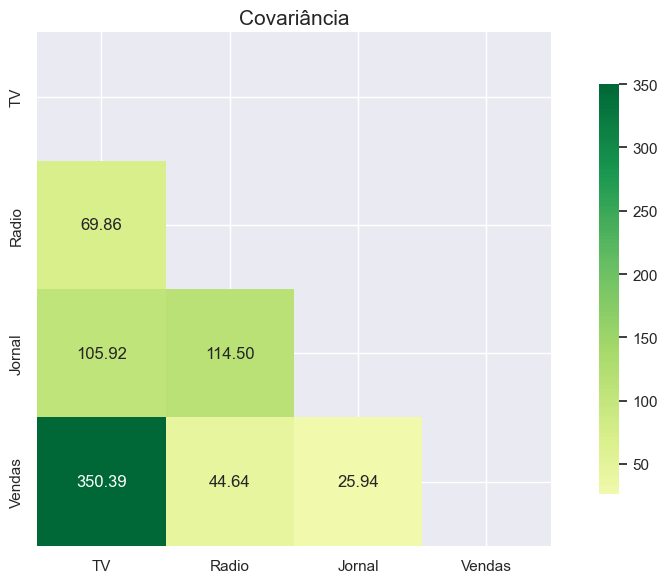

In [38]:
# Mascarar triângulo superior
mask = np.triu(np.ones_like(covariancia_matrix, dtype=bool))
# Construindo o gráfico
plt.figure(figsize=(10,6))
sns.heatmap(covariancia_matrix,annot=True, cmap="RdYlGn", fmt=".2f",center=0,
                   square=True,
                   mask=mask,
                   cbar_kws={"shrink": .8});
plt.title('Covariância',size=15);
plt.tight_layout()
plt.show()

# 4.0 Modelo de regressão

In [39]:
df3 = df2.copy()

## 4.1 Modelo 

In [40]:
y = df3['Vendas'].copy()
x = df3[['TV','Radio','Jornal']].copy()
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Vendas   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           1.58e-96
Time:                        22:17:19   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [41]:
df3['valor_predito'] = model.fittedvalues
df3['residuo']= model.resid
df3.head()

,TV,Radio,Jornal,Vendas,valor_predito,residuo
0,230.10,37.80,69.20,22.10,20.52,1.58
1,44.50,39.30,45.10,10.40,12.34,-1.94
2,17.20,45.90,69.30,9.30,12.31,-3.01
3,151.50,41.30,58.50,18.50,17.60,0.90
4,180.80,10.80,58.40,12.90,13.19,-0.29


## 4.2 Análise de resíduos

### 4.2.1 Gráfico de dispersão do resíduo

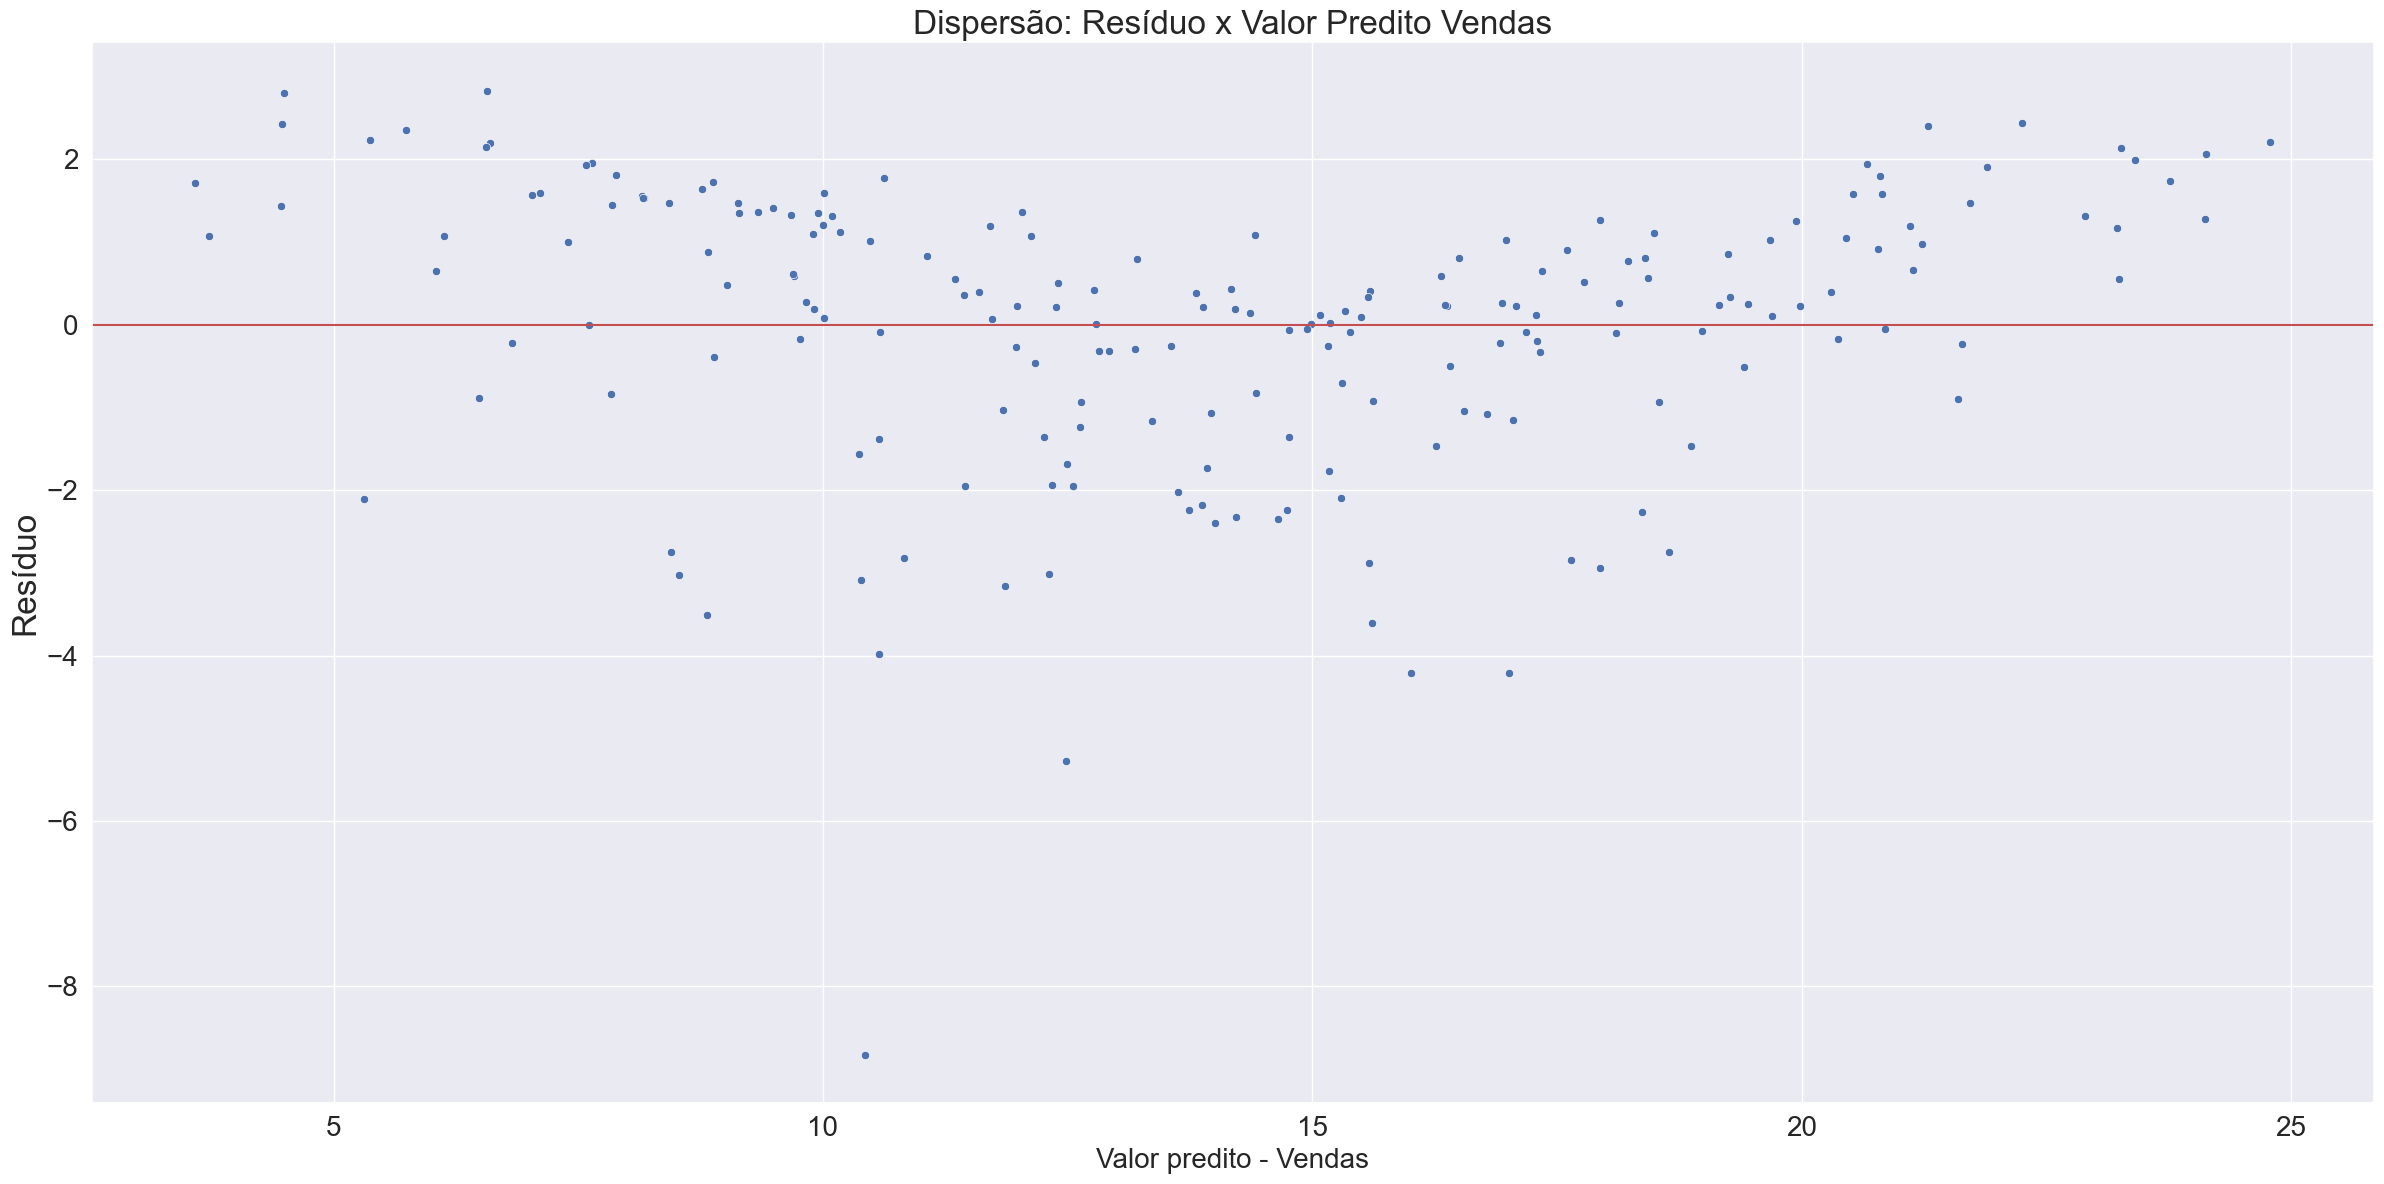

In [42]:
#Dispersao do residuo em funcao do valor predito do resultado vendas
fig = plt.figure( figsize = (24,12) )
                
sns.scatterplot( x = 'valor_predito', y = 'residuo', data = df3 )
plt.axhline(y=0, color='r');

plt.title("Dispersão: Resíduo x Valor Predito Vendas", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor predito - Vendas',fontsize=20)
plt.ylabel('Resíduo',fontsize=24)
plt.tight_layout()
plt.show();

**Análise do gráfico de dispersão**

No gráfico , observa-se um padrão em forma de senoide, onde a dispersão dos resíduos aprensenta oscilações nos valores ajustados, bem como indícios de outliers

Isso pode indicar heterocedasticidade.


### 4.2.2 Teste de Homocedasticidade - Breusch-Pagan

Testa se a variância do erro depende das variáveis explicativas e ocorre quando a variância dos erros não é constante.

Hipóteses:

H0: Homocedasticidade (variância constante dos erros) --> p-valor <0.05

H1: Heteroscedasticidade (variância não constante)

In [43]:
run_breuschpagan_test('com todas as variáveis', model, x)    


--- Teste de Breusch-Pagan para com todas as variáveis ---
Estatística de Teste: 5.1329
P-valor: 0.1623

F-Estatística: 1.7209
P-valor F: 0.1640

Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo com todas as variáveis.


### 4.2.3 Histograma dos resíduos

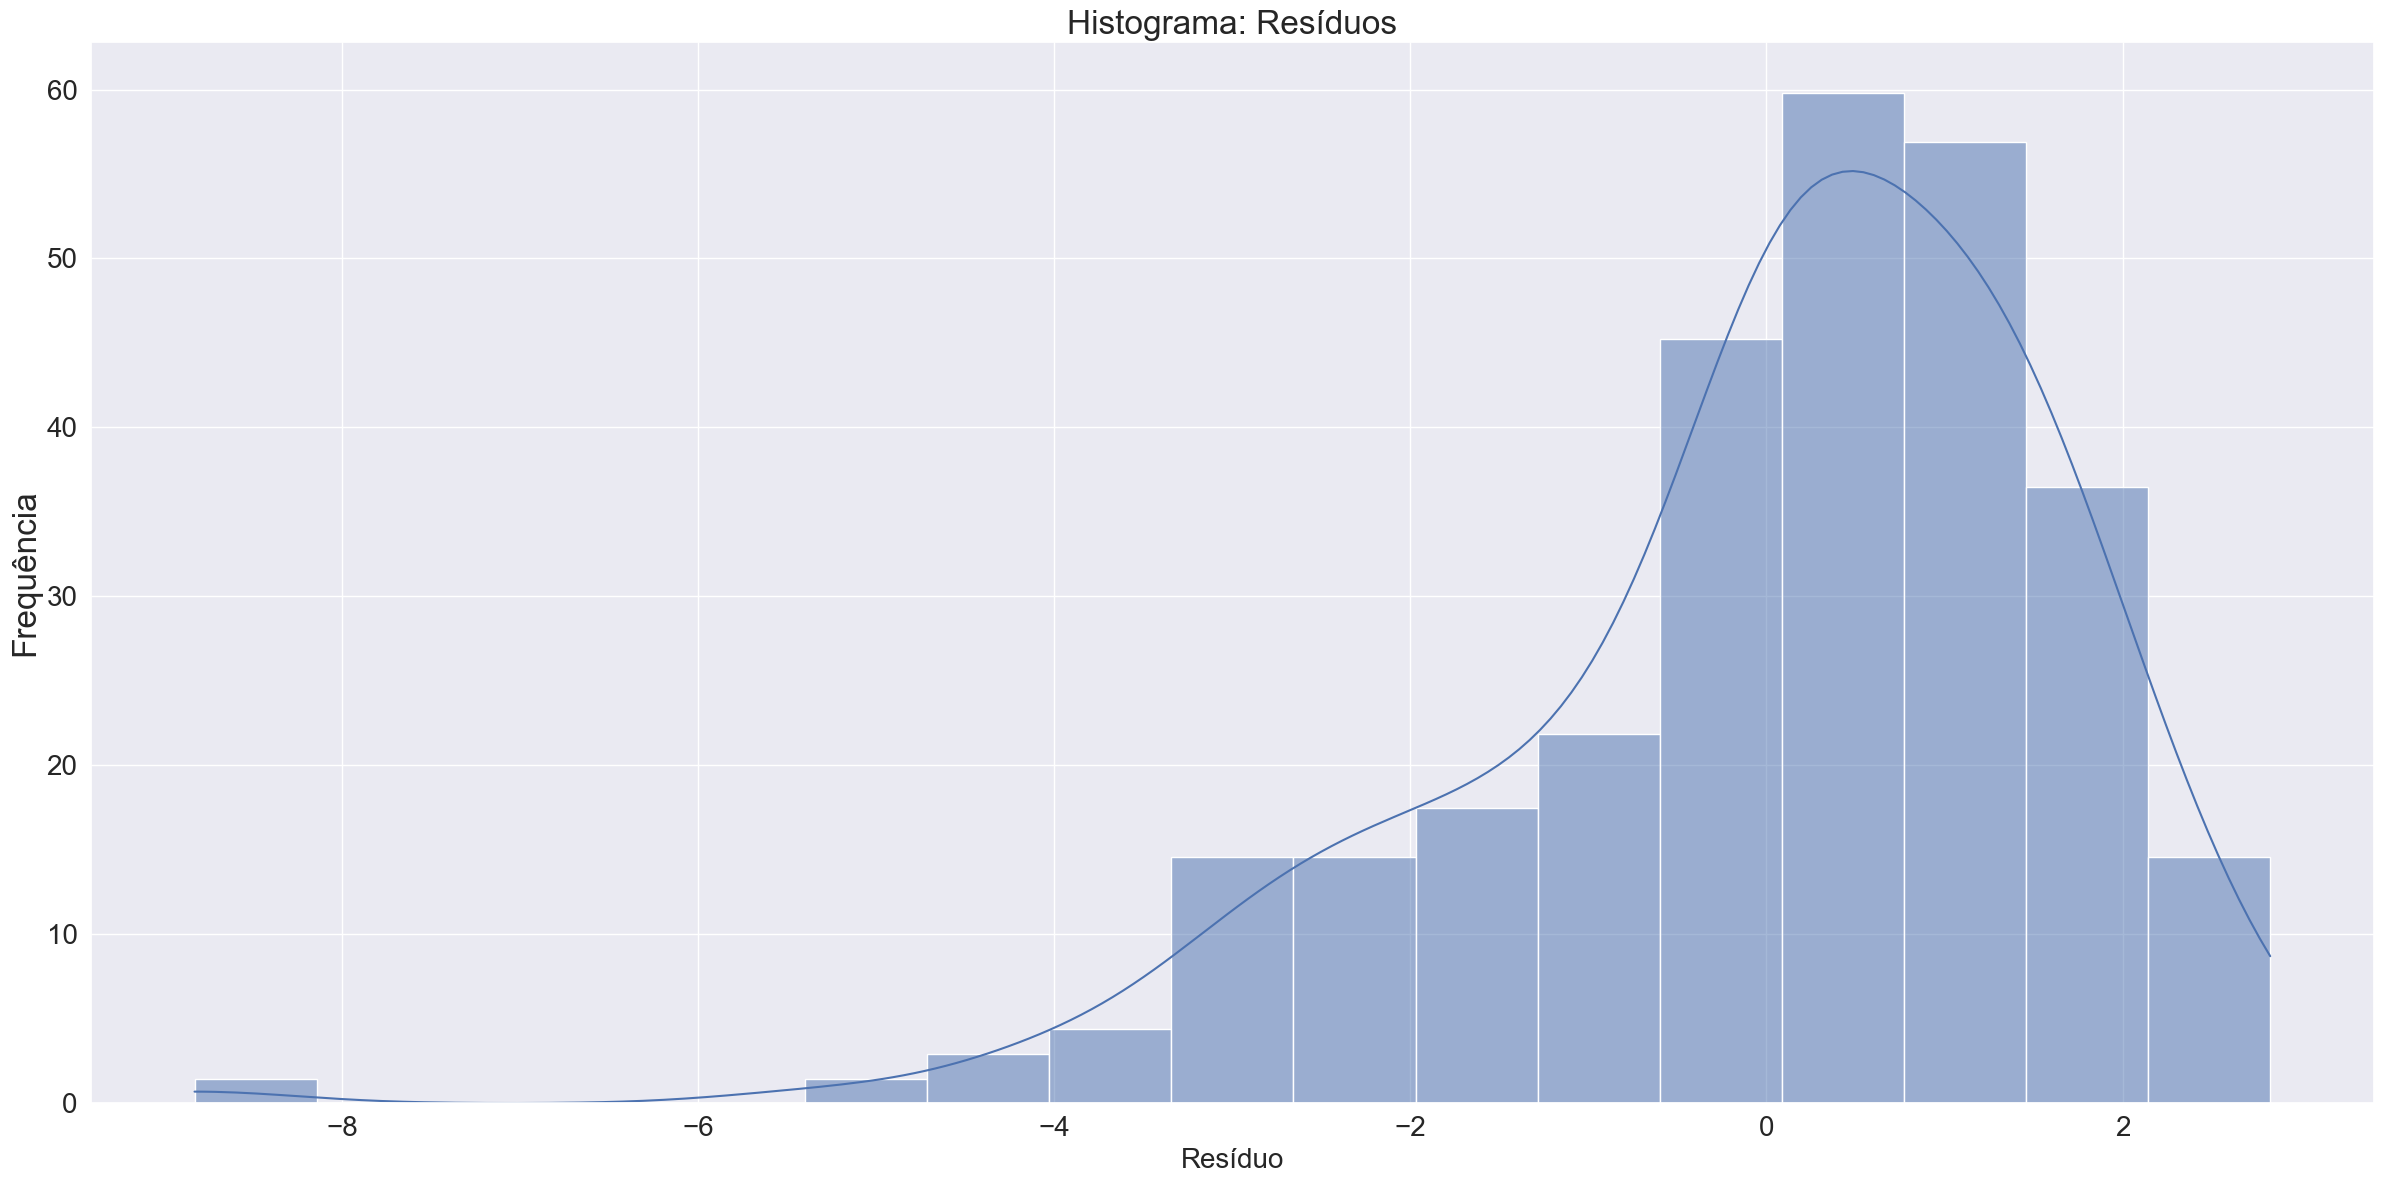

In [44]:
# histograma resíduos
fig = plt.figure( figsize = (24,12) )

sns.histplot( x = 'residuo', data = df3, stat = 'frequency', kde=True);

title("Histograma: Resíduos", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Resíduo',fontsize=20)
plt.ylabel('Frequência',fontsize=24)
plt.tight_layout()
plt.show();

Após a análise do gráfico de histograma há evidencias que os resíduos do modelo não seguem a distribuição normal.

### 4.2.4 Teste de Normalidade dos Resíduos com Shapiro-Wilk

In [45]:
run_shapiro_wilk_test('com todas as variáveis', df3['residuo'])


--- Teste de Shapiro-Wilk para com todas as variáveis ---
Estatística de Teste: 0.9177
P-valor: 0.0000

Conclusão: Rejeitamos H0. Os resíduos do modelo com todas as variáveis não seguem uma distribuição normal.


**Conclusão sobre o teste de Normalidade de Shapiro-Wilk**

**Shapiro-Wilk: p-valor = 0.0000**

Hipóteses:

H0: Os dados seguem uma distribuição normal --> p-valor < 0.05

H1: Os dados não seguem uma distribuição normal

p-valor = 0.0000 < 0.05

Rejeitamos H0. Os resíduos do modelo Modelo não seguem uma distribuição normal.

### 4.2.5 Análise de Normalidade QQ-plot

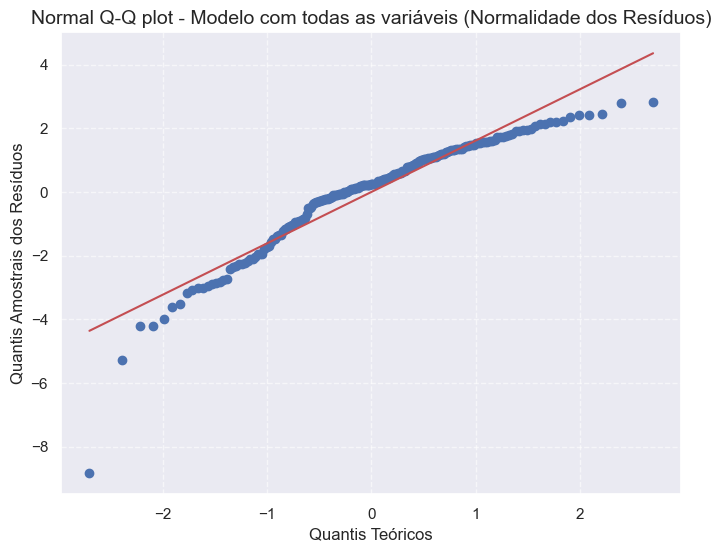

In [46]:
# gráfico Q-Q plot
plot_qq('Modelo com todas as variáveis',  df3['residuo'].values)

Observa-se que os Q-Q plots do modelo indicam que há pontos que se afastam da reta, indicando a mesma conclusão do teste de normalidade.

### 4.2.6 Análise de outliers

In [47]:
mean_resid = np.mean(df3['residuo'] )
std_resid  = np.std(df3['residuo'] )
df3['residuos_std'] = df3['residuo'].apply( lambda x: (x - mean_resid) / std_resid )

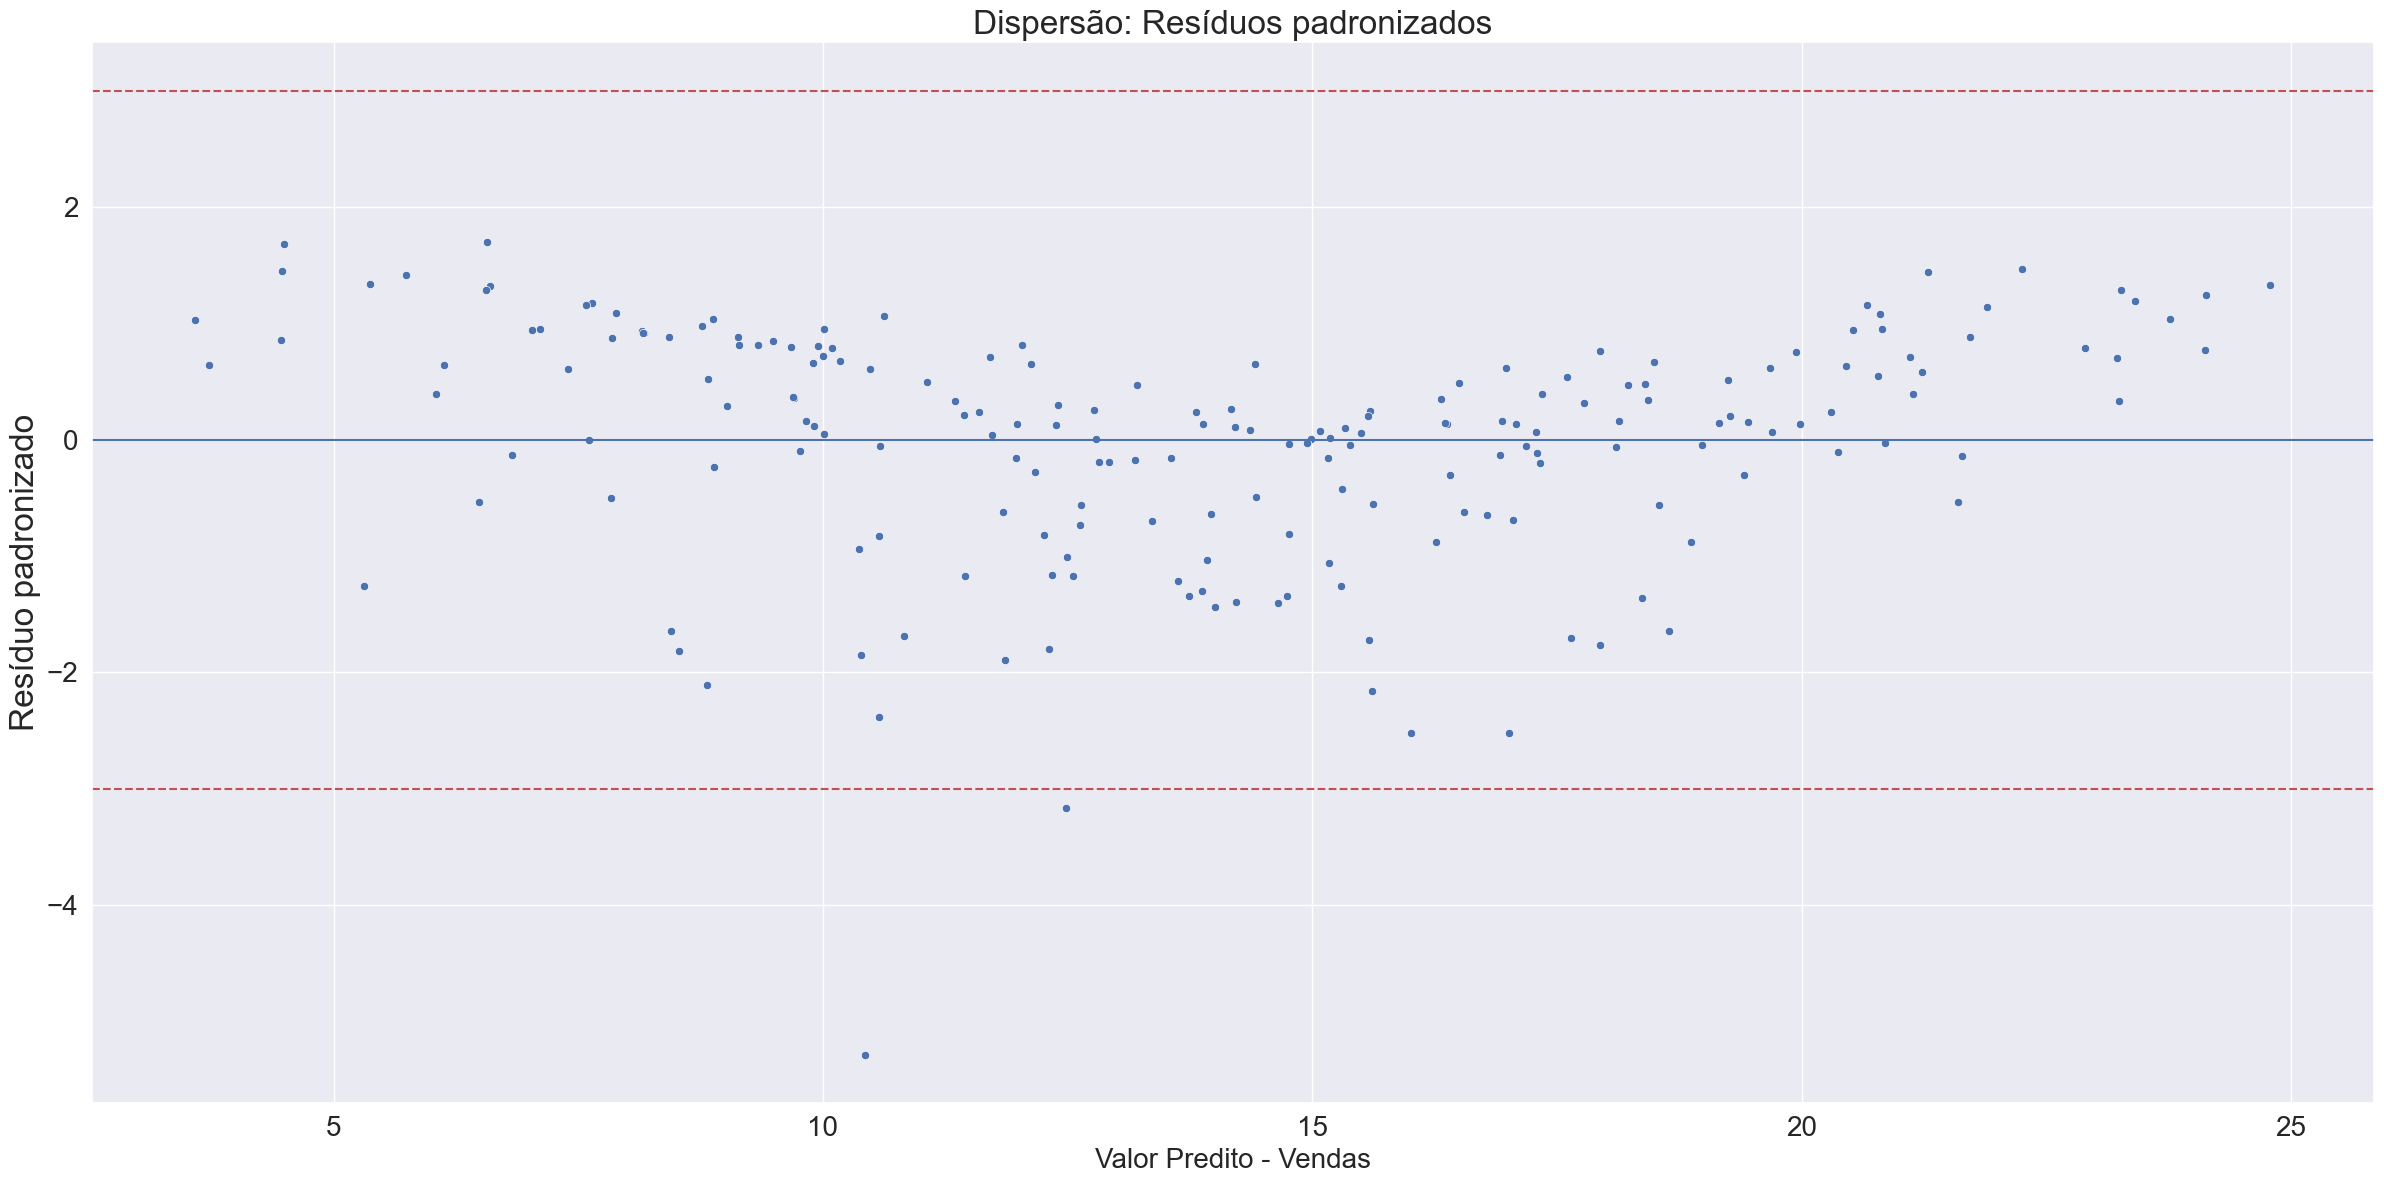

In [48]:
#Dispersao do residuo em funcao do valor predito do resultado vendas
fig = plt.figure( figsize = (24,12) )
sns.scatterplot( x = 'valor_predito', y = 'residuos_std', data = df3 )
plt.axhline(y=0);
plt.axhline(y=3,  linestyle='--', label='Limite Superior (+3)',color='r');
plt.axhline(y=-3, linestyle='--', label='Limite Inferior (-3)',color='r');

title("Dispersão: Resíduos padronizados", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor Predito - Vendas',fontsize=20)
plt.ylabel('Resíduo padronizado',fontsize=24)
plt.tight_layout()
plt.show();


O gráfico apresenta valores que ultrapassam 3 desvios, o que indica que existem outliers que podem distorcer as estimativas do modelo.

### 4.2.7 Análise de autocorrelação dos resíduos

#### Teste de Durbin-Watson

In [49]:
estatistica_dw = durbin_watson(df3['residuo'].values)
print('O valor calculado da estatística do teste de Durbin - Watson corresponde a: {:.4f} '.format(estatistica_dw))

O valor calculado da estatística do teste de Durbin - Watson corresponde a: 2.0836 


**Conclusão sobre o teste de Durbin-Watson**

A estatística DW varia entre 0 e 4.

Interpretação:

1. DW ≈ 2	Sem autocorrelação (resíduos independentes)

2. DW < 2	Autocorrelação positiva (erros consecutivos tendem a ter o mesmo sinal)

3. DW > 2 Autocorrelação negativa (erros alternam sinal entre observações)

**Durbin-Watson = 2.0836 --> Sem autocorrelação o que indica que os resíduos são independentes**



# 5.0 Análise de Multicolinearidade

In [50]:
df5 = df3.copy()
df5.head()

,TV,Radio,Jornal,Vendas,valor_predito,residuo,residuos_std
0,230.10,37.80,69.20,22.10,20.52,1.58,0.94
1,44.50,39.30,45.10,10.40,12.34,-1.94,-1.16
2,17.20,45.90,69.30,9.30,12.31,-3.01,-1.80
3,151.50,41.30,58.50,18.50,17.60,0.90,0.54
4,180.80,10.80,58.40,12.90,13.19,-0.29,-0.17


In [51]:
# Selecionando as variáveis independentes
aux1 = df5[['TV', 'Radio', 'Jornal']].copy()

# lista das variáveis indenpendentes
features_2 = list(aux1.columns)

# variaveis auxiliares r2, tolerancia, FIV
r2  = []
tol = []
fiv=[]

# Calcule VIF para cada variável
for i in aux1.columns:
    
    y = aux1[[i]].copy()
    features_2.remove(i)
    x = aux1[features_2]
    features_2 = list(aux1.columns)

    # modelo
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    predictions = model.predict(x)
                               
    # r2
    r2.append(model.rsquared)
             
    # calculo tolerância
    aux2 = 1- model.rsquared
    tol.append(aux2)
         
    # calculo FIV
    aux3=round(1/(1-model.rsquared),2)
    fiv.append(aux3)
    
tab_multicolinearidade = pd.DataFrame()
tab_multicolinearidade['var_indep'] = list(aux1.columns)
tab_multicolinearidade['r2']  = r2
tab_multicolinearidade['tol'] = tol  
tab_multicolinearidade['fiv'] = fiv  
tab_multicolinearidade

,var_indep,r2,tol,fiv
0,TV,0.00,1.00,1.00
1,Radio,0.13,0.87,1.14
2,Jornal,0.13,0.87,1.15


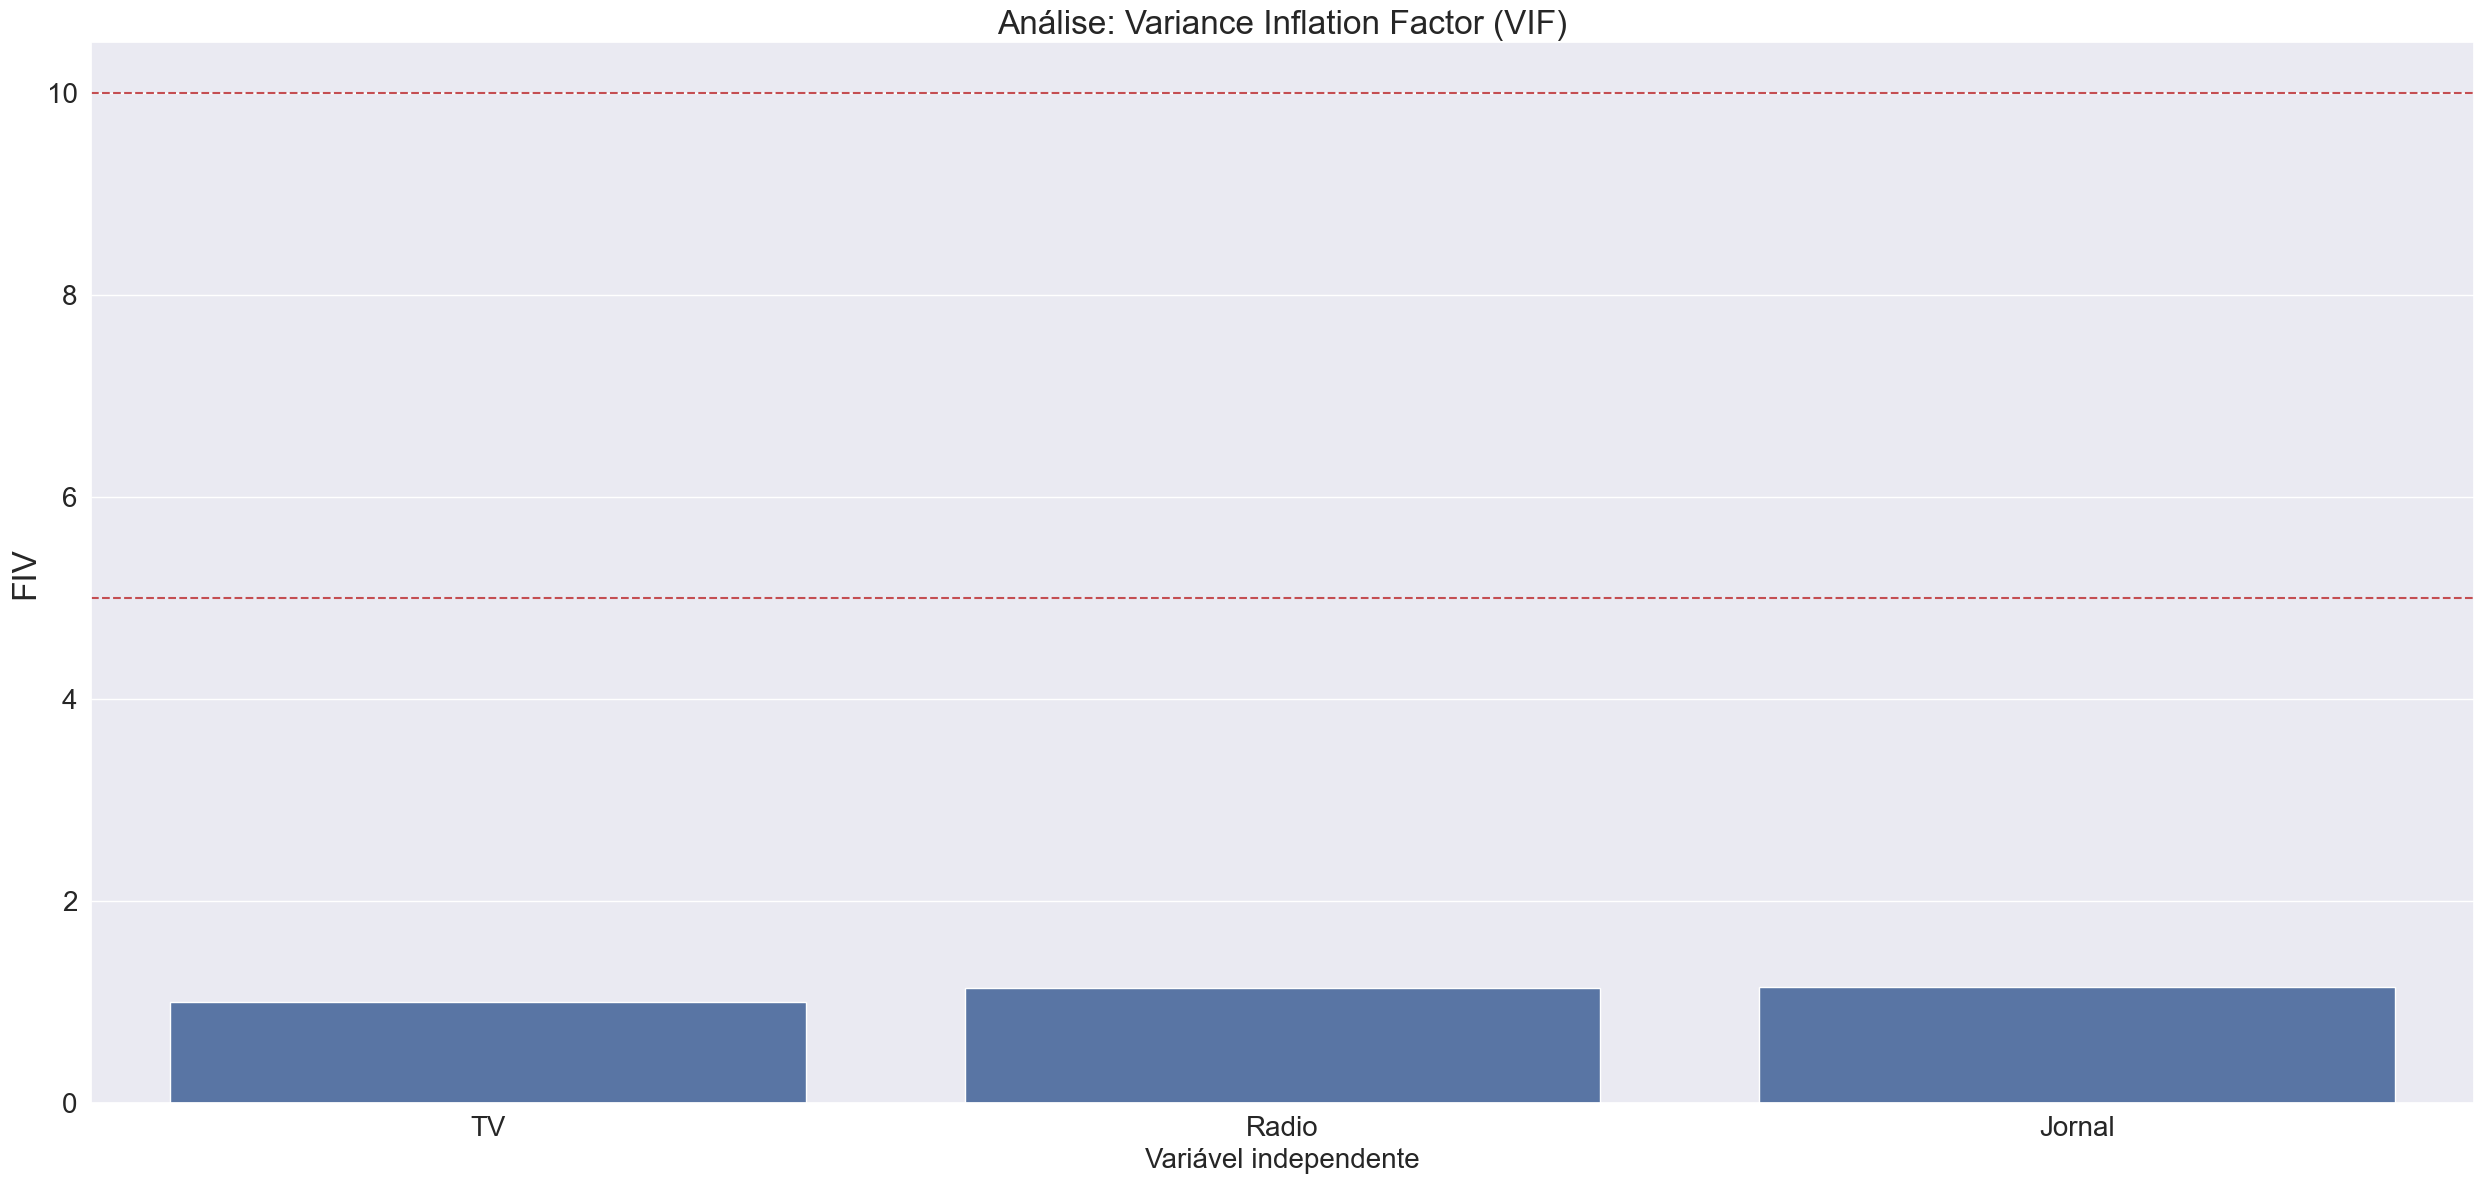

In [52]:
sns.barplot(data=tab_multicolinearidade,y='fiv',x='var_indep');

plt.axhline(y=10,  linestyle='--', label='Limite Superior (+10)',color='r');
plt.axhline(y=5, linestyle='--', label='Limite Inferior (+5)',color='r');

title("Análise: Variance Inflation Factor (VIF)", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Variável independente',fontsize=20)
plt.ylabel('FIV',fontsize=24)
plt.tight_layout()

plt.show();


Após o cálculo do VIF foi possível verificar que não há indicativo de multicolinearidade entre as variáveis independentes do modelo.

# 6.0 Análise do modelo

In [53]:
df6 = df3.copy()
df6.head()

,TV,Radio,Jornal,Vendas,valor_predito,residuo,residuos_std
0,230.10,37.80,69.20,22.10,20.52,1.58,0.94
1,44.50,39.30,45.10,10.40,12.34,-1.94,-1.16
2,17.20,45.90,69.30,9.30,12.31,-3.01,-1.80
3,151.50,41.30,58.50,18.50,17.60,0.90,0.54
4,180.80,10.80,58.40,12.90,13.19,-0.29,-0.17


## 6.1 Modelo

In [54]:
y = df3['Vendas'].copy()
x = df3[['TV','Radio','Jornal']].copy()
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Vendas   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           1.58e-96
Time:                        22:17:20   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

## 6.2 Considerações sobre o modelo de regressão múltipla.

### 6.2.1 Coeficientes de determinação

**Coeficiente de determinação - R quadrado**

O valor do R² = 0.897,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 89.7 % a partir das variáveis independentes utilizadas.

**Coeficiente de determinação ajustado - R² Ajustado**

O valor do Adj. R-squared = 0.0.896,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 89.6 % a partir das variáveis independentes utilizadas.

### 6.2.2 Teste F

**Estatística F - p-valor**

Teste dos coeficientes simultaneamente iguais a zero.

F-statistic: 570.3

Prob (F-statistic): 1.58e-96

Hipoteses:

H0: Todos os coeficientes são simultaneamentes iguais a zero. --> p-valor < 0.05

H1: Pelo menos um dos coeficientes é diferente de zero.

============================================================================================================================================================================

p-valor = 1.58e-96 < 0.05

Rejeita H0: Pelo menos um dos coeficientes é diferente de zero, o Modelo é estaisticamente significativo.

============================================================================================================================================================================


### 6.2.2 Teste t-Student dos coeficientes

**Estatística t-student - p-valor**

Verifica a significância estatística individual de cada coeficiente. 

Hipoteses:

H0: Coeficiente angular da variável é igual a zero. --> p-valor < 0.05

H1: Coeficiente angular é diferente de zero.

============================================================================================================================================================================

const  -- > t=  9.422 --> p-valor= 0.000 --> 

variável independente TV --> t= 32.809 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.

variável independente Radio --> t= 21.893 --> p-valor= 0.000 < 0.05--> **coeficiente é estatisticamente significativo**

variavel independente Jornal -->  t= -0.177 -->  p-valor= 0.860 > 0.05--> <font color='red'>**coeficiente não é estatisticamente significativo** --> Neste modelo a variável não tem efeito sobe a variavel resposta.</f>

============================================================================================================================================================================


### 6.2.3 Expectativas e pressupostos sobre os coeficientes.

**Expectativas e pressupostos**  

Pressuposto: Se a campanha for bem elaborada e adequada ao canal de mídia, é esperado que o investimento em publicidade aumente as vendas. Assim, à medida que se investe mais em publicidade, maior tende a ser o resultado das vendas.

Dessa forma, os sinais dos coeficientes, a priori, devem ser positivos.

============================================================================================================================================================================

**Análise do sinal dos coeficientes do modelo.**

variável independente TV--> Coef= 0.0458 --> **coeficiente positivo**

variável independente Radio --> Coef= 0.1885 -->  **Coeficiente positivo**

variável independente Jornal --> Coef= -0.0010 -->  <font color='red'>**Coeficiente negativo --> Sentido contrário aos pressupostos**</b>

============================================================================================================================================================================


### 6.2.4 Conclusão final da análise

**O modelo com as três variáveis independetes, investimentos de publicdade em "TV", "Radio" e "Jornal", não está corretamente especificado para representar a verdadeira relação com a variável resposta "resultado nas vendas".**

1. Há variáveis estatísticamente irrelevantes no modelo --> O coeficiente da variável "Jornal" não apresenta significancia estatística, bem como o seu respectivo sinal vai contra as expectativas e pressupostos iniciais.
2. Após a análise de normalidade dos resíduos foi possível concluir que há evidências que os resíduos do modelo não seguem a distribuição normal.